In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy, json
# from tqdm.autonotebook import tqdm
from tqdm import tqdm

In [2]:
import torch.optim as optim
from torch.utils import data

In [3]:
from transformers_lib import TransformerBlock, \
        Mixer_TransformerBlock_Encoder, \
        PositionalEncoding

In [4]:
class TinyImageNet_Preload(data.Dataset):
#     https://gist.github.com/z-a-f/b862013c0dc2b540cf96a123a6766e54
    
    def __init__(self, root, mode='train', transform=None, preload=False):
        super().__init__()
        self.preload = preload
        dataset = datasets.ImageFolder(
            root=os.path.join(root, mode),
            transform=None
        )
        self.transform = transform
        self.images, self.labels = [], []
        print("Dataset Size:",len(dataset))
        
        if preload:
            for i in tqdm(range(len(dataset))):
                x, y = dataset[i]
                self.images.append(x)
                self.labels.append(y)
                
#         del dataset
        self.dataset = dataset
            
    def _add_channels(img, total_channels=3):
        while len(img.shape) < 3:  # third axis is the channels
            img = np.expand_dims(img, axis=-1)
        while(img.shape[-1]) < 3:
            img = np.concatenate([img, img[:, :, -1:]], axis=-1)
        return img
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        if self.preload:
            img, lbl = self.images[idx], self.labels[idx]
        else:
            img, lbl = self.dataset[idx]
        return self.transform(img), lbl

# Model

In [5]:
class Mixer_ViT_Classifier(nn.Module):
    
    def __init__(self, image_dim:tuple, patch_size:tuple, hidden_channel:int, num_blocks:int, num_classes:int, block_seq_size:int, block_mlp_size:int, forward_expansion:float=2.0, pos_emb=True, dropout:float=0.0):
        super().__init__()
        
        self.img_dim = image_dim ### must contain (C, H, W) or (H, W)
        
        ### find patch dim
        d0 = int(image_dim[-2]/patch_size[0])
        d1 = int(image_dim[-1]/patch_size[1])
        assert d0*patch_size[0]==image_dim[-2], "Image must be divisible into patch size"
        assert d1*patch_size[1]==image_dim[-1], "Image must be divisible into patch size"
        
#         self.d0, self.d1 = d0, d1 ### number of patches in each axis
        __patch_size = patch_size[0]*patch_size[1]*image_dim[0] ## number of channels in each patch
    
        ### find channel dim
        channel_size = d0*d1 ## number of patches
        
        ### after the number of channels are changed
        init_dim = __patch_size
        final_dim = hidden_channel
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        #### rescale the patches (patch wise image non preserving transform, unlike bilinear interpolation)
        self.channel_change = nn.Linear(init_dim, final_dim)
        print(f"ViT Mixer : Channels per patch -> Initial:{init_dim} Final:{final_dim}")
        
        
        self.channel_dim = final_dim
        self.patch_dim = channel_size
        
        self.transformer_blocks = []
        
        f = self.get_factors(self.channel_dim)
        print(f)
        fi = np.abs(np.array(f) - np.sqrt(self.channel_dim)).argmin()
        
        _n_heads = f[fi]
        
        ## number of dims per channel -> channel_dim
#         print('Num patches:', self.patch_dim)
        print(f'Sequence len: {self.patch_dim} ; Block size: {block_seq_size}')
        print('Channel dim:', self.channel_dim, 'num heads:',_n_heads)
        
        if block_seq_size is None or block_seq_size<2:
            ### Find the block size for sequence:
            block_seq_size = int(2**np.ceil(np.log2(np.sqrt(self.patch_dim))))
            
        print(f'MLP dim: {self.channel_dim} ; Block size: {block_mlp_size}')

        for i in range(num_blocks):
            L = Mixer_TransformerBlock_Encoder(self.patch_dim, block_seq_size, self.channel_dim, _n_heads, dropout, forward_expansion, nn.GELU, block_mlp_size)
            self.transformer_blocks.append(L)
        self.transformer_blocks = nn.Sequential(*self.transformer_blocks)
        
        self.linear = nn.Linear(self.patch_dim*self.channel_dim, num_classes)
        
        self.positional_encoding = PositionalEncoding(self.channel_dim, dropout=0)
        if not pos_emb:
            self.positional_encoding = nn.Identity()
        
        
    def get_factors(self, n):
        facts = []
        for i in range(2, n+1):
            if n%i == 0:
                facts.append(i)
        return facts
    
    def forward(self, x):
        bs = x.shape[0]
        x = self.unfold(x).swapaxes(-1, -2)
        x = self.channel_change(x)
        x = self.positional_encoding(x)
        x = self.transformer_blocks(x)
        x = self.linear(x.view(bs, -1))
        return x

In [6]:
def experiment_skip(model_name, ep):
    if 'sMlp' in model_name:
        return False
    
    filename = f"./output/benchmark/{model_name}_data.json"
    if os.path.exists(filename):
        with open(filename) as f:
            data = json.load(f)
        ## data consists of lists and dicts.
        epochs = data['train_stat'][-1][0]
        if epochs < ep-1:
            return False
    
    return True

In [7]:
def benchmark(dataset:str, patch_size:int, num_layers:int, SEED:int, sparse_att:bool=False, sparse_mlp:bool=False, pos_emb:bool=False, cuda:int=0):
    device = torch.device(f"cuda:{cuda}")
    
    if sparse_att:
        assert num_layers%2 == 0, 'number of blocks on sparse transformer is (x2)/2 hence it must be even'
        num_layers_ = num_layers//2
    else:
        num_layers_ = num_layers
    
    BS = 256
    NC = -1
    EPOCHS = 300
    imsize = (3, 32, 32)
    expansion_dict = {16:1024, 8:256, 4:128, 2:64, 1:64}
    expansion = expansion_dict[patch_size]

    
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    ##### Data Transforms
    if dataset == 'tiny':
        NC = 200
        EPOCHS = 400
        imsize = (3, 64, 64)
        tiny_train = transforms.Compose([
        transforms.RandAugment(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5]*3,
            std=[0.2]*3,
            ),
        ])

        tiny_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5]*3,
                std=[0.2]*3,
            ),
        ])
        
        train_dataset = TinyImageNet_Preload(root="../../../../../_Datasets/tiny-imagenet-200",
                                     mode='train', transform=tiny_train)
        test_dataset = TinyImageNet_Preload(root="../../../../../_Datasets/tiny-imagenet-200",
                                     mode='val', transform=tiny_test)
        
    elif dataset == 'cifar10':
        NC = 10
        BS = 128
        cifar_train = transforms.Compose([
            transforms.RandomCrop(size=32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
                std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
            ),
        ])

        cifar_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
                std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
            ),
        ])

        train_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=True, download=True, transform=cifar_train)
        test_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=False, download=True, transform=cifar_test)

    elif dataset == 'cifar100':
        NC = 100
        BS = 128
        cifar_train = transforms.Compose([
            transforms.RandomCrop(size=32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5071, 0.4865, 0.4409],
                std=[0.2009, 0.1984, 0.2023],
            ),
        ])

        cifar_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5071, 0.4865, 0.4409],
                std=[0.2009, 0.1984, 0.2023],
            ),
        ])

        train_dataset = datasets.CIFAR100(root="../../../../../_Datasets/cifar100/", train=True, download=True, transform=cifar_train)
        test_dataset = datasets.CIFAR100(root="../../../../../_Datasets/cifar100/", train=False, download=True, transform=cifar_test)
        
    ##### Now create data loaders
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BS, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BS, shuffle=False, num_workers=4)
    
    ### Now create models
    
    seq_len = (imsize[-1]*imsize[-2])//(patch_size*patch_size)
    mlp_dim = expansion
    print(seq_len, mlp_dim)
    
    if sparse_att:
        seq_len = int(2**np.ceil(np.log2(np.sqrt(seq_len))))
    if sparse_mlp:
        mlp_dim = int(2**np.ceil(np.log2(np.sqrt(expansion))))
    
    
    torch.manual_seed(SEED)
    model = Mixer_ViT_Classifier(imsize, 
                                 patch_size=[patch_size]*2, 
                                 hidden_channel=expansion, 
                                 num_blocks=num_layers_, 
                                 num_classes=NC, 
                                 block_seq_size=seq_len, 
                                 block_mlp_size=mlp_dim,
                                 pos_emb=pos_emb).to(device)
    
#     _x = torch.randn(BS, *imsize).to(device)
#     print("Output: ",vit_mixer(_x).shape)
    num_params = sum(p.numel() for p in model.parameters())
    print("number of params: ", num_params)
    
    _a, _b, _c = 'att', 'mlp', 'nPE'
    if sparse_att: _a = 'sAtt'
    if sparse_mlp: _b = 'sMlp'
    if pos_emb: _c = 'PE'
    model_name = f'01.3_ViT_{_c}_{dataset}_patch{patch_size}_l{num_layers}_{_a}_{_b}_s{SEED}'
    print(f"Model Name: {model_name}")
    
    if experiment_skip(model_name, EPOCHS):
        print(f'EXPERIMENT DONE... SKIPPING : {model_name}')
        return
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    STAT ={'train_stat':[], 'test_stat':[], 'params':num_params, }

    ## Following is copied from 
    ### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

    # Training
    def train(epoch):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
#             break

        STAT['train_stat'].append((epoch, train_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
        print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
        return

    global best_acc
    best_acc = -1
    def test(epoch):
        global best_acc
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        time_taken = []
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
                inputs, targets = inputs.to(device), targets.to(device)

                start = time.time()

                outputs = model(inputs)

                start = time.time()-start
                time_taken.append(start)

                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        STAT['test_stat'].append((epoch, test_loss/(batch_idx+1), 100.*correct/total, np.mean(time_taken))) ### (Epochs, Loss, Acc, time)
        print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")

        # Save checkpoint.
        acc = 100.*correct/total
        if acc > best_acc:
            print('Saving..')
            state = {
                'model': model.state_dict(),
                'acc': acc,
                'epoch': epoch
            }
            if not os.path.isdir('models'):
                os.mkdir('models')
            torch.save(state, f'./models/benchmark/{model_name}.pth')
            best_acc = acc

        with open(f"./output/benchmark/{model_name}_data.json", 'w') as f:
            json.dump(STAT, f, indent=0)

    ### Train the whole damn thing
#     EPOCHS = 1
    for epoch in range(0, EPOCHS):
        train(epoch)
        test(epoch)
        scheduler.step()
        
    
    train_stat = np.array(STAT['train_stat'])
    test_stat = np.array(STAT['test_stat'])

    plt.plot(train_stat[:,1], label='train')
    plt.plot(test_stat[:,1], label='test')
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"./output/benchmark/plots/{model_name}_loss.svg")
    plt.show()

    plt.plot(train_stat[:,2], label='train')
    plt.plot(test_stat[:,2], label='test')
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f"./output/benchmark/plots/{model_name}_accs.svg")
    plt.show()
    
    del model, optimizer
    return

In [8]:
# benchmark(dataset='tiny', 
#           patch_size=4, num_layers=10, SEED=123, sparse_att=True, sparse_mlp=True, cuda=0
#          )

In [9]:
# ### Automate the benchmark
# ###### for tiny
# cuda_idx = 0
# # for seed in [147, 258, 369]:
# for seed in [147]:
#     for patch_size in [16, 8, 4]:
#         for sparse_attention in [False, True]:
#             for sparse_mlp in [False, True]:
# #                 for nlayers in [6, 10, 14]:
#                 for nlayers in [6]:
#                     print(f'''
#                         Experimenting on Tiny Dataset 
#                         patch:{patch_size},
#                         sparse_att: {sparse_attention},
#                         sparse_mlp: {sparse_mlp},
#                         num_layers : {nlayers},
#                         seed: {seed}
#                     ''')
            
#                     benchmark(dataset='tiny', 
#                               patch_size=patch_size, 
#                               num_layers=nlayers, 
#                               SEED=seed, 
#                               sparse_att=sparse_attention, sparse_mlp=sparse_mlp, 
#                               cuda=cuda_idx
#                              )


In [10]:
# ### Automate the benchmark
# ###### for tiny

# not_working = [
#     (4, False, True, 6),
#     (4, False, False, 10),
#     (4, False, False, 14),
#     (4, False, True, 10),
#     (4, False, True, 14),
#     (4, True, True, 14),
# ]

# cuda_idx = 0
# for seed in [147, 258, 369]:
# # for seed in [147]:
#     for patch_size in [16, 8, 4]:
#         for sparse_attention in [False, True]:
#             for sparse_mlp in [False, True]:
#                 for nlayers in [6, 10, 14]:

#                     print(f'''
#                         Experimenting on Tiny Dataset 
#                         patch:{patch_size},
#                         sparse_att: {sparse_attention},
#                         sparse_mlp: {sparse_mlp},
#                         num_layers : {nlayers},
#                         seed: {seed}
#                     ''')
            
#                 ### check if config is in not_working case
#                     exit = False
#                     for nw in not_working:
#                         if patch_size==nw[0] and \
#                             sparse_attention==nw[1] and \
#                             sparse_mlp==nw[2] and\
#                             nlayers==nw[3]:
                            
#                             exit=True
#                             break
#                     if exit:
#                         print(f'Exiting as the config is in NOT WORKING')
#                         continue


#                     benchmark(dataset='tiny', 
#                               patch_size=patch_size, 
#                               num_layers=nlayers, 
#                               SEED=seed, 
#                               sparse_att=sparse_attention, sparse_mlp=sparse_mlp, 
#                               cuda=cuda_idx
#                              )



                                Experimenting on cifar10 Dataset 
                                patch:8,
                                sparse_att: False,
                                sparse_mlp: False,
                                num_layers: 4,
                                pos_embed: True,
                                seed: 147
                            
Files already downloaded and verified
Files already downloaded and verified
16 256
ViT Mixer : Channels per patch -> Initial:192 Final:256
[2, 4, 8, 16, 32, 64, 128, 256]
Sequence len: 16 ; Block size: 16
Channel dim: 256 num heads: 16
MLP dim: 256 ; Block size: 256
number of params:  2198794
Model Name: 01.3_ViT_PE_cifar10_patch8_l4_att_mlp_s147
EXPERIMENT DONE... SKIPPING : 01.3_ViT_PE_cifar10_patch8_l4_att_mlp_s147

                                Experimenting on cifar10 Dataset 
                                patch:8,
                                sparse_att: False,
                                sparse_mlp

100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.90it/s]


[Train] 0 Loss: 1.923 | Acc: 29.094 14547/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.57it/s]


[Test] 0 Loss: 1.706 | Acc: 38.240 3824/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.81it/s]


[Train] 1 Loss: 1.677 | Acc: 38.828 19414/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.34it/s]


[Test] 1 Loss: 1.547 | Acc: 44.090 4409/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.60it/s]


[Train] 2 Loss: 1.577 | Acc: 42.554 21277/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.20it/s]


[Test] 2 Loss: 1.506 | Acc: 46.540 4654/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.54it/s]


[Train] 3 Loss: 1.520 | Acc: 44.968 22484/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.96it/s]


[Test] 3 Loss: 1.440 | Acc: 48.780 4878/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.61it/s]


[Train] 4 Loss: 1.476 | Acc: 46.400 23200/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.99it/s]


[Test] 4 Loss: 1.397 | Acc: 50.190 5019/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.46it/s]


[Train] 5 Loss: 1.442 | Acc: 47.984 23992/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.12it/s]


[Test] 5 Loss: 1.388 | Acc: 50.540 5054/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.48it/s]


[Train] 6 Loss: 1.407 | Acc: 49.186 24593/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.19it/s]


[Test] 6 Loss: 1.369 | Acc: 51.470 5147/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.56it/s]


[Train] 7 Loss: 1.379 | Acc: 50.296 25148/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.52it/s]


[Test] 7 Loss: 1.322 | Acc: 53.160 5316/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.57it/s]


[Train] 8 Loss: 1.353 | Acc: 51.320 25660/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.04it/s]


[Test] 8 Loss: 1.322 | Acc: 52.430 5243/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.68it/s]


[Train] 9 Loss: 1.334 | Acc: 51.944 25972/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 98.01it/s]


[Test] 9 Loss: 1.283 | Acc: 54.330 5433/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.76it/s]


[Train] 10 Loss: 1.314 | Acc: 52.772 26386/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.96it/s]


[Test] 10 Loss: 1.283 | Acc: 54.060 5406/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.73it/s]


[Train] 11 Loss: 1.297 | Acc: 53.206 26603/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.13it/s]


[Test] 11 Loss: 1.265 | Acc: 54.670 5467/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.69it/s]


[Train] 12 Loss: 1.277 | Acc: 54.318 27159/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.72it/s]


[Test] 12 Loss: 1.249 | Acc: 55.470 5547/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.64it/s]


[Train] 13 Loss: 1.263 | Acc: 54.534 27267/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.33it/s]


[Test] 13 Loss: 1.260 | Acc: 55.160 5516/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.83it/s]


[Train] 14 Loss: 1.247 | Acc: 55.120 27560/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.18it/s]


[Test] 14 Loss: 1.234 | Acc: 56.190 5619/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.67it/s]


[Train] 15 Loss: 1.235 | Acc: 55.678 27839/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.25it/s]


[Test] 15 Loss: 1.200 | Acc: 57.140 5714/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.51it/s]


[Train] 16 Loss: 1.228 | Acc: 55.884 27942/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.30it/s]


[Test] 16 Loss: 1.191 | Acc: 57.360 5736/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.52it/s]


[Train] 17 Loss: 1.208 | Acc: 56.920 28460/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.94it/s]


[Test] 17 Loss: 1.188 | Acc: 57.670 5767/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.59it/s]


[Train] 18 Loss: 1.196 | Acc: 57.310 28655/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.18it/s]


[Test] 18 Loss: 1.196 | Acc: 57.090 5709/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.72it/s]


[Train] 19 Loss: 1.187 | Acc: 57.446 28723/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.09it/s]


[Test] 19 Loss: 1.197 | Acc: 56.980 5698/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.67it/s]


[Train] 20 Loss: 1.180 | Acc: 57.532 28766/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.69it/s]


[Test] 20 Loss: 1.172 | Acc: 57.950 5795/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.53it/s]


[Train] 21 Loss: 1.166 | Acc: 58.096 29048/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.22it/s]


[Test] 21 Loss: 1.179 | Acc: 57.310 5731/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.58it/s]


[Train] 22 Loss: 1.160 | Acc: 58.262 29131/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.80it/s]


[Test] 22 Loss: 1.170 | Acc: 58.430 5843/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.61it/s]


[Train] 23 Loss: 1.148 | Acc: 59.030 29515/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.62it/s]


[Test] 23 Loss: 1.149 | Acc: 59.220 5922/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.68it/s]


[Train] 24 Loss: 1.137 | Acc: 59.336 29668/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.37it/s]


[Test] 24 Loss: 1.143 | Acc: 59.580 5958/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.45it/s]


[Train] 25 Loss: 1.128 | Acc: 59.528 29764/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.33it/s]


[Test] 25 Loss: 1.170 | Acc: 58.720 5872/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.67it/s]


[Train] 26 Loss: 1.124 | Acc: 59.738 29869/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.30it/s]


[Test] 26 Loss: 1.129 | Acc: 60.430 6043/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.50it/s]


[Train] 27 Loss: 1.115 | Acc: 60.294 30147/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.26it/s]


[Test] 27 Loss: 1.147 | Acc: 59.650 5965/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.62it/s]


[Train] 28 Loss: 1.106 | Acc: 60.288 30144/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.62it/s]


[Test] 28 Loss: 1.134 | Acc: 60.050 6005/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.58it/s]


[Train] 29 Loss: 1.103 | Acc: 60.570 30285/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.06it/s]


[Test] 29 Loss: 1.111 | Acc: 60.600 6060/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.71it/s]


[Train] 30 Loss: 1.092 | Acc: 60.972 30486/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.68it/s]


[Test] 30 Loss: 1.106 | Acc: 60.850 6085/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.57it/s]


[Train] 31 Loss: 1.077 | Acc: 61.500 30750/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.59it/s]


[Test] 31 Loss: 1.106 | Acc: 60.970 6097/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.55it/s]


[Train] 32 Loss: 1.072 | Acc: 61.712 30856/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.13it/s]


[Test] 32 Loss: 1.102 | Acc: 60.620 6062/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.72it/s]


[Train] 33 Loss: 1.064 | Acc: 61.726 30863/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.41it/s]


[Test] 33 Loss: 1.089 | Acc: 60.910 6091/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.60it/s]


[Train] 34 Loss: 1.060 | Acc: 62.302 31151/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.27it/s]


[Test] 34 Loss: 1.105 | Acc: 60.500 6050/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.77it/s]


[Train] 35 Loss: 1.057 | Acc: 61.906 30953/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.26it/s]


[Test] 35 Loss: 1.082 | Acc: 61.550 6155/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.44it/s]


[Train] 36 Loss: 1.046 | Acc: 62.610 31305/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.56it/s]


[Test] 36 Loss: 1.095 | Acc: 61.710 6171/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.04it/s]


[Train] 37 Loss: 1.042 | Acc: 62.588 31294/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.80it/s]


[Test] 37 Loss: 1.063 | Acc: 62.280 6228/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.55it/s]


[Train] 38 Loss: 1.036 | Acc: 63.130 31565/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.00it/s]


[Test] 38 Loss: 1.065 | Acc: 62.310 6231/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.64it/s]


[Train] 39 Loss: 1.031 | Acc: 63.142 31571/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.74it/s]


[Test] 39 Loss: 1.067 | Acc: 62.090 6209/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.57it/s]


[Train] 40 Loss: 1.018 | Acc: 63.706 31853/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.61it/s]


[Test] 40 Loss: 1.062 | Acc: 62.670 6267/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.64it/s]


[Train] 41 Loss: 1.019 | Acc: 63.448 31724/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.82it/s]


[Test] 41 Loss: 1.063 | Acc: 62.930 6293/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.57it/s]


[Train] 42 Loss: 1.017 | Acc: 63.708 31854/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.89it/s]


[Test] 42 Loss: 1.063 | Acc: 62.620 6262/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.64it/s]


[Train] 43 Loss: 1.004 | Acc: 64.260 32130/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.34it/s]


[Test] 43 Loss: 1.051 | Acc: 63.230 6323/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.58it/s]


[Train] 44 Loss: 0.997 | Acc: 64.394 32197/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.83it/s]


[Test] 44 Loss: 1.056 | Acc: 62.800 6280/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.72it/s]


[Train] 45 Loss: 0.993 | Acc: 64.808 32404/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.75it/s]


[Test] 45 Loss: 1.044 | Acc: 63.100 6310/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.69it/s]


[Train] 46 Loss: 0.990 | Acc: 64.414 32207/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.35it/s]


[Test] 46 Loss: 1.056 | Acc: 62.750 6275/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.65it/s]


[Train] 47 Loss: 0.987 | Acc: 64.832 32416/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.57it/s]


[Test] 47 Loss: 1.042 | Acc: 63.090 6309/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.64it/s]


[Train] 48 Loss: 0.981 | Acc: 64.976 32488/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.49it/s]


[Test] 48 Loss: 1.034 | Acc: 63.380 6338/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.57it/s]


[Train] 49 Loss: 0.972 | Acc: 65.294 32647/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.60it/s]


[Test] 49 Loss: 1.039 | Acc: 63.380 6338/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.66it/s]


[Train] 50 Loss: 0.966 | Acc: 65.396 32698/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.30it/s]


[Test] 50 Loss: 1.033 | Acc: 63.960 6396/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.44it/s]


[Train] 51 Loss: 0.963 | Acc: 65.696 32848/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.31it/s]


[Test] 51 Loss: 1.040 | Acc: 63.170 6317/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.68it/s]


[Train] 52 Loss: 0.957 | Acc: 65.852 32926/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.27it/s]


[Test] 52 Loss: 1.024 | Acc: 63.860 6386/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.65it/s]


[Train] 53 Loss: 0.953 | Acc: 65.836 32918/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.17it/s]


[Test] 53 Loss: 1.033 | Acc: 64.120 6412/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.64it/s]


[Train] 54 Loss: 0.954 | Acc: 66.158 33079/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.32it/s]


[Test] 54 Loss: 1.022 | Acc: 64.610 6461/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.77it/s]


[Train] 55 Loss: 0.943 | Acc: 66.474 33237/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.13it/s]


[Test] 55 Loss: 1.026 | Acc: 63.910 6391/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.77it/s]


[Train] 56 Loss: 0.936 | Acc: 66.478 33239/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.53it/s]


[Test] 56 Loss: 1.018 | Acc: 64.300 6430/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.91it/s]


[Train] 57 Loss: 0.936 | Acc: 66.696 33348/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.31it/s]


[Test] 57 Loss: 1.012 | Acc: 65.030 6503/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.99it/s]


[Train] 58 Loss: 0.929 | Acc: 66.836 33418/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.79it/s]


[Test] 58 Loss: 1.014 | Acc: 64.540 6454/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.79it/s]


[Train] 59 Loss: 0.922 | Acc: 67.172 33586/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.73it/s]


[Test] 59 Loss: 1.021 | Acc: 64.290 6429/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.64it/s]


[Train] 60 Loss: 0.927 | Acc: 66.952 33476/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.31it/s]


[Test] 60 Loss: 1.018 | Acc: 64.440 6444/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.91it/s]


[Train] 61 Loss: 0.918 | Acc: 67.218 33609/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.49it/s]


[Test] 61 Loss: 1.020 | Acc: 64.750 6475/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.63it/s]


[Train] 62 Loss: 0.920 | Acc: 67.158 33579/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.23it/s]


[Test] 62 Loss: 1.001 | Acc: 64.940 6494/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.62it/s]


[Train] 63 Loss: 0.907 | Acc: 67.722 33861/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.03it/s]


[Test] 63 Loss: 0.999 | Acc: 65.360 6536/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.84it/s]


[Train] 64 Loss: 0.907 | Acc: 67.722 33861/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.10it/s]


[Test] 64 Loss: 0.996 | Acc: 65.410 6541/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.85it/s]


[Train] 65 Loss: 0.897 | Acc: 67.876 33938/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.83it/s]


[Test] 65 Loss: 1.006 | Acc: 65.020 6502/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.93it/s]


[Train] 66 Loss: 0.900 | Acc: 68.036 34018/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.95it/s]


[Test] 66 Loss: 1.016 | Acc: 65.050 6505/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.61it/s]


[Train] 67 Loss: 0.896 | Acc: 68.144 34072/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.00it/s]


[Test] 67 Loss: 1.002 | Acc: 64.860 6486/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.83it/s]


[Train] 68 Loss: 0.889 | Acc: 68.372 34186/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.73it/s]


[Test] 68 Loss: 1.012 | Acc: 64.980 6498/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.61it/s]


[Train] 69 Loss: 0.885 | Acc: 68.400 34200/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.55it/s]


[Test] 69 Loss: 0.999 | Acc: 65.550 6555/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.75it/s]


[Train] 70 Loss: 0.877 | Acc: 68.786 34393/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.62it/s]


[Test] 70 Loss: 1.010 | Acc: 64.600 6460/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.77it/s]


[Train] 71 Loss: 0.877 | Acc: 68.714 34357/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.79it/s]


[Test] 71 Loss: 1.012 | Acc: 64.390 6439/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 45.07it/s]


[Train] 72 Loss: 0.872 | Acc: 68.936 34468/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.63it/s]


[Test] 72 Loss: 0.994 | Acc: 65.430 6543/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.67it/s]


[Train] 73 Loss: 0.869 | Acc: 69.062 34531/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.15it/s]


[Test] 73 Loss: 0.991 | Acc: 65.410 6541/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.92it/s]


[Train] 74 Loss: 0.867 | Acc: 68.946 34473/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.92it/s]


[Test] 74 Loss: 0.986 | Acc: 65.520 6552/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 75 Loss: 0.867 | Acc: 68.994 34497/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.23it/s]


[Test] 75 Loss: 1.002 | Acc: 65.050 6505/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 76 Loss: 0.856 | Acc: 69.584 34792/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.03it/s]


[Test] 76 Loss: 0.995 | Acc: 65.850 6585/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.66it/s]


[Train] 77 Loss: 0.858 | Acc: 69.370 34685/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.33it/s]


[Test] 77 Loss: 0.985 | Acc: 66.040 6604/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.46it/s]


[Train] 78 Loss: 0.849 | Acc: 69.662 34831/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.55it/s]


[Test] 78 Loss: 0.994 | Acc: 65.450 6545/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.51it/s]


[Train] 79 Loss: 0.846 | Acc: 69.728 34864/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.57it/s]


[Test] 79 Loss: 1.009 | Acc: 64.670 6467/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.42it/s]


[Train] 80 Loss: 0.846 | Acc: 69.810 34905/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.06it/s]


[Test] 80 Loss: 0.979 | Acc: 65.670 6567/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.71it/s]


[Train] 81 Loss: 0.838 | Acc: 70.054 35027/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.80it/s]


[Test] 81 Loss: 0.974 | Acc: 66.230 6623/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.55it/s]


[Train] 82 Loss: 0.834 | Acc: 70.328 35164/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.61it/s]


[Test] 82 Loss: 0.990 | Acc: 65.260 6526/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.72it/s]


[Train] 83 Loss: 0.833 | Acc: 70.252 35126/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.17it/s]


[Test] 83 Loss: 0.985 | Acc: 65.910 6591/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.65it/s]


[Train] 84 Loss: 0.832 | Acc: 70.430 35215/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.33it/s]


[Test] 84 Loss: 0.970 | Acc: 66.110 6611/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.60it/s]


[Train] 85 Loss: 0.833 | Acc: 70.420 35210/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.25it/s]


[Test] 85 Loss: 0.980 | Acc: 66.380 6638/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.42it/s]


[Train] 86 Loss: 0.821 | Acc: 70.686 35343/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.61it/s]


[Test] 86 Loss: 0.988 | Acc: 65.760 6576/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.29it/s]


[Train] 87 Loss: 0.820 | Acc: 70.740 35370/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.83it/s]


[Test] 87 Loss: 0.972 | Acc: 66.130 6613/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 88 Loss: 0.818 | Acc: 70.630 35315/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.01it/s]


[Test] 88 Loss: 0.970 | Acc: 66.610 6661/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.22it/s]


[Train] 89 Loss: 0.808 | Acc: 71.116 35558/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.98it/s]


[Test] 89 Loss: 0.962 | Acc: 67.110 6711/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.52it/s]


[Train] 90 Loss: 0.808 | Acc: 71.272 35636/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.92it/s]


[Test] 90 Loss: 0.958 | Acc: 67.140 6714/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.23it/s]


[Train] 91 Loss: 0.810 | Acc: 71.122 35561/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.19it/s]


[Test] 91 Loss: 0.954 | Acc: 66.910 6691/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.80it/s]


[Train] 92 Loss: 0.800 | Acc: 71.514 35757/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.22it/s]


[Test] 92 Loss: 0.967 | Acc: 66.600 6660/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.42it/s]


[Train] 93 Loss: 0.801 | Acc: 71.376 35688/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.82it/s]


[Test] 93 Loss: 0.959 | Acc: 66.910 6691/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.51it/s]


[Train] 94 Loss: 0.794 | Acc: 71.532 35766/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.31it/s]


[Test] 94 Loss: 0.962 | Acc: 66.950 6695/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.34it/s]


[Train] 95 Loss: 0.797 | Acc: 71.452 35726/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.18it/s]


[Test] 95 Loss: 0.957 | Acc: 66.630 6663/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.82it/s]


[Train] 96 Loss: 0.790 | Acc: 72.050 36025/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.81it/s]


[Test] 96 Loss: 0.956 | Acc: 66.820 6682/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.82it/s]


[Train] 97 Loss: 0.784 | Acc: 72.026 36013/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.29it/s]


[Test] 97 Loss: 0.960 | Acc: 66.660 6666/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.69it/s]


[Train] 98 Loss: 0.783 | Acc: 71.992 35996/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.57it/s]


[Test] 98 Loss: 0.956 | Acc: 66.880 6688/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.67it/s]


[Train] 99 Loss: 0.781 | Acc: 72.006 36003/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.35it/s]


[Test] 99 Loss: 0.970 | Acc: 66.830 6683/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.53it/s]


[Train] 100 Loss: 0.775 | Acc: 72.532 36266/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.76it/s]


[Test] 100 Loss: 0.966 | Acc: 66.670 6667/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.59it/s]


[Train] 101 Loss: 0.776 | Acc: 72.256 36128/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.34it/s]


[Test] 101 Loss: 0.963 | Acc: 66.630 6663/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.40it/s]


[Train] 102 Loss: 0.773 | Acc: 72.230 36115/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.04it/s]


[Test] 102 Loss: 0.951 | Acc: 67.350 6735/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.40it/s]


[Train] 103 Loss: 0.767 | Acc: 72.802 36401/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.36it/s]


[Test] 103 Loss: 0.969 | Acc: 66.500 6650/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.36it/s]


[Train] 104 Loss: 0.766 | Acc: 72.568 36284/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.59it/s]


[Test] 104 Loss: 0.973 | Acc: 66.480 6648/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 105 Loss: 0.759 | Acc: 72.952 36476/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.84it/s]


[Test] 105 Loss: 0.956 | Acc: 67.260 6726/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.61it/s]


[Train] 106 Loss: 0.760 | Acc: 72.798 36399/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.90it/s]


[Test] 106 Loss: 0.958 | Acc: 66.930 6693/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.44it/s]


[Train] 107 Loss: 0.758 | Acc: 72.762 36381/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.37it/s]


[Test] 107 Loss: 0.964 | Acc: 66.500 6650/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.67it/s]


[Train] 108 Loss: 0.752 | Acc: 72.918 36459/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.74it/s]


[Test] 108 Loss: 0.961 | Acc: 66.850 6685/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.85it/s]


[Train] 109 Loss: 0.748 | Acc: 73.264 36632/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.02it/s]


[Test] 109 Loss: 0.961 | Acc: 66.730 6673/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.53it/s]


[Train] 110 Loss: 0.753 | Acc: 73.008 36504/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.00it/s]


[Test] 110 Loss: 0.960 | Acc: 67.270 6727/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.09it/s]


[Train] 111 Loss: 0.748 | Acc: 73.202 36601/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.22it/s]


[Test] 111 Loss: 0.957 | Acc: 67.330 6733/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.57it/s]


[Train] 112 Loss: 0.737 | Acc: 73.628 36814/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.01it/s]


[Test] 112 Loss: 0.963 | Acc: 67.140 6714/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.28it/s]


[Train] 113 Loss: 0.735 | Acc: 73.518 36759/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.48it/s]


[Test] 113 Loss: 0.950 | Acc: 67.780 6778/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.43it/s]


[Train] 114 Loss: 0.742 | Acc: 73.602 36801/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.50it/s]


[Test] 114 Loss: 0.966 | Acc: 66.880 6688/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.46it/s]


[Train] 115 Loss: 0.741 | Acc: 73.532 36766/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.64it/s]


[Test] 115 Loss: 0.956 | Acc: 67.290 6729/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.34it/s]


[Train] 116 Loss: 0.729 | Acc: 73.964 36982/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.64it/s]


[Test] 116 Loss: 0.956 | Acc: 67.320 6732/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.69it/s]


[Train] 117 Loss: 0.728 | Acc: 74.148 37074/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.56it/s]


[Test] 117 Loss: 0.979 | Acc: 66.450 6645/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.46it/s]


[Train] 118 Loss: 0.726 | Acc: 74.020 37010/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.19it/s]


[Test] 118 Loss: 0.955 | Acc: 67.530 6753/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.40it/s]


[Train] 119 Loss: 0.723 | Acc: 74.452 37226/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.70it/s]


[Test] 119 Loss: 0.958 | Acc: 67.300 6730/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.35it/s]


[Train] 120 Loss: 0.719 | Acc: 74.304 37152/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.26it/s]


[Test] 120 Loss: 0.970 | Acc: 67.290 6729/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.76it/s]


[Train] 121 Loss: 0.716 | Acc: 74.634 37317/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.73it/s]


[Test] 121 Loss: 0.942 | Acc: 67.860 6786/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.72it/s]


[Train] 122 Loss: 0.713 | Acc: 74.404 37202/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.94it/s]


[Test] 122 Loss: 0.947 | Acc: 67.920 6792/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.43it/s]


[Train] 123 Loss: 0.709 | Acc: 74.636 37318/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.33it/s]


[Test] 123 Loss: 0.956 | Acc: 67.640 6764/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.48it/s]


[Train] 124 Loss: 0.708 | Acc: 74.870 37435/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.48it/s]


[Test] 124 Loss: 0.964 | Acc: 67.540 6754/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.35it/s]


[Train] 125 Loss: 0.706 | Acc: 74.822 37411/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.33it/s]


[Test] 125 Loss: 0.956 | Acc: 67.670 6767/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.49it/s]


[Train] 126 Loss: 0.707 | Acc: 74.834 37417/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.52it/s]


[Test] 126 Loss: 0.963 | Acc: 67.920 6792/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.41it/s]


[Train] 127 Loss: 0.701 | Acc: 75.050 37525/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.25it/s]


[Test] 127 Loss: 0.955 | Acc: 67.500 6750/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.10it/s]


[Train] 128 Loss: 0.703 | Acc: 75.112 37556/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.88it/s]


[Test] 128 Loss: 0.963 | Acc: 67.800 6780/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.61it/s]


[Train] 129 Loss: 0.699 | Acc: 75.094 37547/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.92it/s]


[Test] 129 Loss: 0.957 | Acc: 67.460 6746/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.70it/s]


[Train] 130 Loss: 0.691 | Acc: 75.374 37687/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.94it/s]


[Test] 130 Loss: 0.949 | Acc: 67.860 6786/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.57it/s]


[Train] 131 Loss: 0.692 | Acc: 75.534 37767/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.59it/s]


[Test] 131 Loss: 0.952 | Acc: 67.160 6716/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.60it/s]


[Train] 132 Loss: 0.689 | Acc: 75.160 37580/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.59it/s]


[Test] 132 Loss: 0.957 | Acc: 67.540 6754/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.68it/s]


[Train] 133 Loss: 0.685 | Acc: 75.352 37676/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.96it/s]


[Test] 133 Loss: 0.957 | Acc: 67.640 6764/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.64it/s]


[Train] 134 Loss: 0.685 | Acc: 75.512 37756/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.63it/s]


[Test] 134 Loss: 0.950 | Acc: 67.520 6752/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.77it/s]


[Train] 135 Loss: 0.680 | Acc: 75.628 37814/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.74it/s]


[Test] 135 Loss: 0.967 | Acc: 67.470 6747/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.39it/s]


[Train] 136 Loss: 0.680 | Acc: 75.804 37902/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.48it/s]


[Test] 136 Loss: 0.956 | Acc: 68.090 6809/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.35it/s]


[Train] 137 Loss: 0.677 | Acc: 75.712 37856/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.34it/s]


[Test] 137 Loss: 0.962 | Acc: 67.490 6749/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.69it/s]


[Train] 138 Loss: 0.677 | Acc: 75.852 37926/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.07it/s]


[Test] 138 Loss: 0.960 | Acc: 67.850 6785/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.52it/s]


[Train] 139 Loss: 0.671 | Acc: 75.886 37943/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.96it/s]


[Test] 139 Loss: 0.954 | Acc: 67.770 6777/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.52it/s]


[Train] 140 Loss: 0.669 | Acc: 76.098 38049/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.42it/s]


[Test] 140 Loss: 0.954 | Acc: 68.100 6810/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.63it/s]


[Train] 141 Loss: 0.667 | Acc: 76.178 38089/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.01it/s]


[Test] 141 Loss: 0.950 | Acc: 68.140 6814/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.55it/s]


[Train] 142 Loss: 0.668 | Acc: 76.084 38042/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.51it/s]


[Test] 142 Loss: 0.961 | Acc: 67.720 6772/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.45it/s]


[Train] 143 Loss: 0.660 | Acc: 76.266 38133/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.03it/s]


[Test] 143 Loss: 0.952 | Acc: 67.840 6784/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.35it/s]


[Train] 144 Loss: 0.662 | Acc: 76.430 38215/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.43it/s]


[Test] 144 Loss: 0.956 | Acc: 67.910 6791/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.23it/s]


[Train] 145 Loss: 0.665 | Acc: 76.290 38145/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.74it/s]


[Test] 145 Loss: 0.949 | Acc: 68.070 6807/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.66it/s]


[Train] 146 Loss: 0.660 | Acc: 76.494 38247/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.20it/s]


[Test] 146 Loss: 0.951 | Acc: 68.020 6802/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.64it/s]


[Train] 147 Loss: 0.653 | Acc: 76.564 38282/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.62it/s]


[Test] 147 Loss: 0.953 | Acc: 68.230 6823/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.79it/s]


[Train] 148 Loss: 0.652 | Acc: 76.824 38412/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.19it/s]


[Test] 148 Loss: 0.954 | Acc: 67.790 6779/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.66it/s]


[Train] 149 Loss: 0.650 | Acc: 76.950 38475/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.38it/s]


[Test] 149 Loss: 0.948 | Acc: 68.120 6812/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.28it/s]


[Train] 150 Loss: 0.650 | Acc: 76.716 38358/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.24it/s]


[Test] 150 Loss: 0.967 | Acc: 67.600 6760/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.49it/s]


[Train] 151 Loss: 0.645 | Acc: 77.074 38537/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.42it/s]


[Test] 151 Loss: 0.957 | Acc: 67.710 6771/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.60it/s]


[Train] 152 Loss: 0.648 | Acc: 76.876 38438/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.86it/s]


[Test] 152 Loss: 0.967 | Acc: 68.080 6808/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.48it/s]


[Train] 153 Loss: 0.642 | Acc: 77.112 38556/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.21it/s]


[Test] 153 Loss: 0.966 | Acc: 67.700 6770/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.54it/s]


[Train] 154 Loss: 0.643 | Acc: 77.032 38516/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.43it/s]


[Test] 154 Loss: 0.953 | Acc: 68.480 6848/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.55it/s]


[Train] 155 Loss: 0.640 | Acc: 77.056 38528/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.85it/s]


[Test] 155 Loss: 0.964 | Acc: 67.940 6794/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.42it/s]


[Train] 156 Loss: 0.636 | Acc: 77.246 38623/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.04it/s]


[Test] 156 Loss: 0.968 | Acc: 68.250 6825/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.56it/s]


[Train] 157 Loss: 0.639 | Acc: 77.282 38641/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.34it/s]


[Test] 157 Loss: 0.960 | Acc: 68.210 6821/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.56it/s]


[Train] 158 Loss: 0.631 | Acc: 77.640 38820/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.98it/s]


[Test] 158 Loss: 0.962 | Acc: 68.350 6835/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.61it/s]


[Train] 159 Loss: 0.638 | Acc: 77.234 38617/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.70it/s]


[Test] 159 Loss: 0.951 | Acc: 68.400 6840/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.65it/s]


[Train] 160 Loss: 0.631 | Acc: 77.360 38680/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.98it/s]


[Test] 160 Loss: 0.973 | Acc: 67.960 6796/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.87it/s]


[Train] 161 Loss: 0.626 | Acc: 77.808 38904/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.50it/s]


[Test] 161 Loss: 0.954 | Acc: 68.250 6825/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.52it/s]


[Train] 162 Loss: 0.627 | Acc: 77.624 38812/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.94it/s]


[Test] 162 Loss: 0.949 | Acc: 68.260 6826/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.25it/s]


[Train] 163 Loss: 0.625 | Acc: 77.810 38905/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.43it/s]


[Test] 163 Loss: 0.960 | Acc: 68.430 6843/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.48it/s]


[Train] 164 Loss: 0.624 | Acc: 77.738 38869/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.25it/s]


[Test] 164 Loss: 0.965 | Acc: 68.080 6808/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.64it/s]


[Train] 165 Loss: 0.619 | Acc: 77.790 38895/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.10it/s]


[Test] 165 Loss: 0.970 | Acc: 68.180 6818/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.50it/s]


[Train] 166 Loss: 0.622 | Acc: 77.730 38865/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.44it/s]


[Test] 166 Loss: 0.961 | Acc: 68.330 6833/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.51it/s]


[Train] 167 Loss: 0.616 | Acc: 78.116 39058/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.24it/s]


[Test] 167 Loss: 0.962 | Acc: 68.240 6824/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.60it/s]


[Train] 168 Loss: 0.613 | Acc: 78.058 39029/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.30it/s]


[Test] 168 Loss: 0.956 | Acc: 68.330 6833/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.72it/s]


[Train] 169 Loss: 0.613 | Acc: 78.066 39033/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.83it/s]


[Test] 169 Loss: 0.964 | Acc: 68.550 6855/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.16it/s]


[Train] 170 Loss: 0.606 | Acc: 78.248 39124/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.36it/s]


[Test] 170 Loss: 0.960 | Acc: 68.450 6845/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.68it/s]


[Train] 171 Loss: 0.606 | Acc: 78.332 39166/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.47it/s]


[Test] 171 Loss: 0.968 | Acc: 68.570 6857/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.82it/s]


[Train] 172 Loss: 0.610 | Acc: 78.344 39172/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.18it/s]


[Test] 172 Loss: 0.962 | Acc: 68.410 6841/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.79it/s]


[Train] 173 Loss: 0.607 | Acc: 78.384 39192/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.84it/s]


[Test] 173 Loss: 0.954 | Acc: 68.490 6849/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.45it/s]


[Train] 174 Loss: 0.601 | Acc: 78.500 39250/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.68it/s]


[Test] 174 Loss: 0.962 | Acc: 68.540 6854/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.51it/s]


[Train] 175 Loss: 0.600 | Acc: 78.700 39350/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.80it/s]


[Test] 175 Loss: 0.957 | Acc: 68.310 6831/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.59it/s]


[Train] 176 Loss: 0.601 | Acc: 78.568 39284/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.06it/s]


[Test] 176 Loss: 0.969 | Acc: 68.250 6825/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.75it/s]


[Train] 177 Loss: 0.591 | Acc: 78.992 39496/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.85it/s]


[Test] 177 Loss: 0.966 | Acc: 68.570 6857/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.33it/s]


[Train] 178 Loss: 0.594 | Acc: 78.826 39413/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.47it/s]


[Test] 178 Loss: 0.962 | Acc: 68.180 6818/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.28it/s]


[Train] 179 Loss: 0.593 | Acc: 78.682 39341/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.43it/s]


[Test] 179 Loss: 0.965 | Acc: 68.080 6808/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.45it/s]


[Train] 180 Loss: 0.592 | Acc: 78.726 39363/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.12it/s]


[Test] 180 Loss: 0.966 | Acc: 68.150 6815/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.60it/s]


[Train] 181 Loss: 0.593 | Acc: 78.816 39408/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.84it/s]


[Test] 181 Loss: 0.959 | Acc: 68.410 6841/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.59it/s]


[Train] 182 Loss: 0.590 | Acc: 78.970 39485/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.67it/s]


[Test] 182 Loss: 0.971 | Acc: 67.920 6792/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.55it/s]


[Train] 183 Loss: 0.591 | Acc: 78.720 39360/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.31it/s]


[Test] 183 Loss: 0.964 | Acc: 68.550 6855/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.45it/s]


[Train] 184 Loss: 0.585 | Acc: 78.992 39496/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.80it/s]


[Test] 184 Loss: 0.965 | Acc: 68.270 6827/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.49it/s]


[Train] 185 Loss: 0.586 | Acc: 79.206 39603/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.38it/s]


[Test] 185 Loss: 0.966 | Acc: 68.280 6828/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.83it/s]


[Train] 186 Loss: 0.586 | Acc: 79.004 39502/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.10it/s]


[Test] 186 Loss: 0.962 | Acc: 68.280 6828/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.27it/s]


[Train] 187 Loss: 0.584 | Acc: 79.318 39659/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.09it/s]


[Test] 187 Loss: 0.970 | Acc: 68.240 6824/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.59it/s]


[Train] 188 Loss: 0.578 | Acc: 79.300 39650/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.73it/s]


[Test] 188 Loss: 0.979 | Acc: 68.310 6831/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 189 Loss: 0.585 | Acc: 79.262 39631/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.45it/s]


[Test] 189 Loss: 0.963 | Acc: 68.080 6808/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.44it/s]


[Train] 190 Loss: 0.578 | Acc: 79.456 39728/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.61it/s]


[Test] 190 Loss: 0.976 | Acc: 68.330 6833/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.55it/s]


[Train] 191 Loss: 0.574 | Acc: 79.452 39726/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.37it/s]


[Test] 191 Loss: 0.964 | Acc: 68.440 6844/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.40it/s]


[Train] 192 Loss: 0.577 | Acc: 79.394 39697/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.73it/s]


[Test] 192 Loss: 0.971 | Acc: 68.170 6817/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.42it/s]


[Train] 193 Loss: 0.571 | Acc: 79.642 39821/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.64it/s]


[Test] 193 Loss: 0.968 | Acc: 68.260 6826/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.43it/s]


[Train] 194 Loss: 0.577 | Acc: 79.322 39661/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.57it/s]


[Test] 194 Loss: 0.977 | Acc: 68.060 6806/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.75it/s]


[Train] 195 Loss: 0.571 | Acc: 79.534 39767/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.36it/s]


[Test] 195 Loss: 0.969 | Acc: 68.220 6822/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.63it/s]


[Train] 196 Loss: 0.568 | Acc: 79.860 39930/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.95it/s]


[Test] 196 Loss: 0.975 | Acc: 68.520 6852/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.43it/s]


[Train] 197 Loss: 0.565 | Acc: 79.822 39911/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.15it/s]


[Test] 197 Loss: 0.967 | Acc: 68.600 6860/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.62it/s]


[Train] 198 Loss: 0.561 | Acc: 80.054 40027/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.72it/s]


[Test] 198 Loss: 0.973 | Acc: 68.300 6830/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.98it/s]


[Train] 199 Loss: 0.566 | Acc: 79.918 39959/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.73it/s]


[Test] 199 Loss: 0.971 | Acc: 68.370 6837/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.62it/s]


[Train] 200 Loss: 0.564 | Acc: 79.760 39880/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.94it/s]


[Test] 200 Loss: 0.973 | Acc: 68.250 6825/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.15it/s]


[Train] 201 Loss: 0.560 | Acc: 79.904 39952/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.32it/s]


[Test] 201 Loss: 0.974 | Acc: 68.270 6827/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.17it/s]


[Train] 202 Loss: 0.562 | Acc: 79.912 39956/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.34it/s]


[Test] 202 Loss: 0.985 | Acc: 67.850 6785/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.41it/s]


[Train] 203 Loss: 0.558 | Acc: 79.862 39931/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.64it/s]


[Test] 203 Loss: 0.982 | Acc: 68.050 6805/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.65it/s]


[Train] 204 Loss: 0.559 | Acc: 80.110 40055/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.97it/s]


[Test] 204 Loss: 0.965 | Acc: 68.460 6846/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.45it/s]


[Train] 205 Loss: 0.560 | Acc: 80.152 40076/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.74it/s]


[Test] 205 Loss: 0.978 | Acc: 68.040 6804/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.69it/s]


[Train] 206 Loss: 0.556 | Acc: 80.282 40141/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.37it/s]


[Test] 206 Loss: 0.983 | Acc: 68.240 6824/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.24it/s]


[Train] 207 Loss: 0.555 | Acc: 80.112 40056/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.34it/s]


[Test] 207 Loss: 0.974 | Acc: 68.520 6852/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.65it/s]


[Train] 208 Loss: 0.554 | Acc: 80.136 40068/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.32it/s]


[Test] 208 Loss: 0.977 | Acc: 68.260 6826/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.42it/s]


[Train] 209 Loss: 0.550 | Acc: 80.444 40222/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.00it/s]


[Test] 209 Loss: 0.977 | Acc: 68.300 6830/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.49it/s]


[Train] 210 Loss: 0.549 | Acc: 80.330 40165/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.54it/s]


[Test] 210 Loss: 0.975 | Acc: 68.120 6812/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.55it/s]


[Train] 211 Loss: 0.550 | Acc: 80.340 40170/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.05it/s]


[Test] 211 Loss: 0.981 | Acc: 68.360 6836/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.60it/s]


[Train] 212 Loss: 0.546 | Acc: 80.462 40231/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.63it/s]


[Test] 212 Loss: 0.978 | Acc: 68.350 6835/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.52it/s]


[Train] 213 Loss: 0.549 | Acc: 80.272 40136/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.49it/s]


[Test] 213 Loss: 0.979 | Acc: 68.190 6819/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.52it/s]


[Train] 214 Loss: 0.546 | Acc: 80.408 40204/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.18it/s]


[Test] 214 Loss: 0.980 | Acc: 67.870 6787/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.65it/s]


[Train] 215 Loss: 0.548 | Acc: 80.344 40172/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.73it/s]


[Test] 215 Loss: 0.974 | Acc: 68.530 6853/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.64it/s]


[Train] 216 Loss: 0.550 | Acc: 80.492 40246/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.82it/s]


[Test] 216 Loss: 0.980 | Acc: 68.280 6828/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.63it/s]


[Train] 217 Loss: 0.544 | Acc: 80.518 40259/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.79it/s]


[Test] 217 Loss: 0.976 | Acc: 68.440 6844/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.58it/s]


[Train] 218 Loss: 0.545 | Acc: 80.396 40198/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.88it/s]


[Test] 218 Loss: 0.972 | Acc: 68.490 6849/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.51it/s]


[Train] 219 Loss: 0.540 | Acc: 80.810 40405/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.03it/s]


[Test] 219 Loss: 0.974 | Acc: 68.280 6828/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.74it/s]


[Train] 220 Loss: 0.541 | Acc: 80.840 40420/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.18it/s]


[Test] 220 Loss: 0.975 | Acc: 68.360 6836/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.44it/s]


[Train] 221 Loss: 0.537 | Acc: 80.914 40457/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.82it/s]


[Test] 221 Loss: 0.980 | Acc: 68.000 6800/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.35it/s]


[Train] 222 Loss: 0.540 | Acc: 80.946 40473/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.69it/s]


[Test] 222 Loss: 0.973 | Acc: 68.210 6821/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.63it/s]


[Train] 223 Loss: 0.538 | Acc: 80.802 40401/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.73it/s]


[Test] 223 Loss: 0.975 | Acc: 68.380 6838/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.45it/s]


[Train] 224 Loss: 0.535 | Acc: 80.910 40455/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.92it/s]


[Test] 224 Loss: 0.979 | Acc: 68.420 6842/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.76it/s]


[Train] 225 Loss: 0.534 | Acc: 81.100 40550/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.43it/s]


[Test] 225 Loss: 0.979 | Acc: 68.360 6836/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.70it/s]


[Train] 226 Loss: 0.535 | Acc: 80.910 40455/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.68it/s]


[Test] 226 Loss: 0.979 | Acc: 68.450 6845/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.65it/s]


[Train] 227 Loss: 0.540 | Acc: 80.748 40374/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.67it/s]


[Test] 227 Loss: 0.980 | Acc: 68.470 6847/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.39it/s]


[Train] 228 Loss: 0.534 | Acc: 80.916 40458/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.08it/s]


[Test] 228 Loss: 0.977 | Acc: 68.470 6847/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.59it/s]


[Train] 229 Loss: 0.532 | Acc: 81.050 40525/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.12it/s]


[Test] 229 Loss: 0.977 | Acc: 68.360 6836/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.31it/s]


[Train] 230 Loss: 0.539 | Acc: 80.792 40396/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.46it/s]


[Test] 230 Loss: 0.977 | Acc: 68.420 6842/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.58it/s]


[Train] 231 Loss: 0.535 | Acc: 80.830 40415/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.96it/s]


[Test] 231 Loss: 0.978 | Acc: 68.460 6846/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.35it/s]


[Train] 232 Loss: 0.528 | Acc: 81.106 40553/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.20it/s]


[Test] 232 Loss: 0.982 | Acc: 68.270 6827/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.31it/s]


[Train] 233 Loss: 0.529 | Acc: 80.986 40493/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.44it/s]


[Test] 233 Loss: 0.982 | Acc: 68.590 6859/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.44it/s]


[Train] 234 Loss: 0.529 | Acc: 81.152 40576/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.37it/s]


[Test] 234 Loss: 0.983 | Acc: 68.310 6831/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.66it/s]


[Train] 235 Loss: 0.526 | Acc: 81.262 40631/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.94it/s]


[Test] 235 Loss: 0.981 | Acc: 68.520 6852/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.27it/s]


[Train] 236 Loss: 0.528 | Acc: 81.260 40630/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.14it/s]


[Test] 236 Loss: 0.982 | Acc: 68.220 6822/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.43it/s]


[Train] 237 Loss: 0.524 | Acc: 81.224 40612/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.44it/s]


[Test] 237 Loss: 0.981 | Acc: 68.400 6840/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.82it/s]


[Train] 238 Loss: 0.528 | Acc: 81.154 40577/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.70it/s]


[Test] 238 Loss: 0.984 | Acc: 68.360 6836/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.54it/s]


[Train] 239 Loss: 0.524 | Acc: 81.356 40678/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.81it/s]


[Test] 239 Loss: 0.983 | Acc: 68.250 6825/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.39it/s]


[Train] 240 Loss: 0.525 | Acc: 81.378 40689/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.81it/s]


[Test] 240 Loss: 0.981 | Acc: 68.430 6843/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.45it/s]


[Train] 241 Loss: 0.522 | Acc: 81.390 40695/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.72it/s]


[Test] 241 Loss: 0.982 | Acc: 68.420 6842/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.75it/s]


[Train] 242 Loss: 0.524 | Acc: 81.282 40641/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.66it/s]


[Test] 242 Loss: 0.983 | Acc: 68.190 6819/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.61it/s]


[Train] 243 Loss: 0.527 | Acc: 81.222 40611/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.75it/s]


[Test] 243 Loss: 0.979 | Acc: 68.460 6846/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.50it/s]


[Train] 244 Loss: 0.524 | Acc: 81.448 40724/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.42it/s]


[Test] 244 Loss: 0.981 | Acc: 68.310 6831/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.28it/s]


[Train] 245 Loss: 0.518 | Acc: 81.598 40799/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.16it/s]


[Test] 245 Loss: 0.983 | Acc: 68.250 6825/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.43it/s]


[Train] 246 Loss: 0.521 | Acc: 81.362 40681/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.92it/s]


[Test] 246 Loss: 0.983 | Acc: 68.190 6819/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.55it/s]


[Train] 247 Loss: 0.520 | Acc: 81.502 40751/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.40it/s]


[Test] 247 Loss: 0.984 | Acc: 68.170 6817/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.44it/s]


[Train] 248 Loss: 0.518 | Acc: 81.568 40784/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.15it/s]


[Test] 248 Loss: 0.981 | Acc: 68.390 6839/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.27it/s]


[Train] 249 Loss: 0.514 | Acc: 81.818 40909/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.45it/s]


[Test] 249 Loss: 0.985 | Acc: 68.120 6812/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.52it/s]


[Train] 250 Loss: 0.518 | Acc: 81.546 40773/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 76.41it/s]


[Test] 250 Loss: 0.985 | Acc: 68.220 6822/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.94it/s]


[Train] 251 Loss: 0.518 | Acc: 81.546 40773/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.53it/s]


[Test] 251 Loss: 0.989 | Acc: 68.480 6848/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.65it/s]


[Train] 252 Loss: 0.512 | Acc: 81.880 40940/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.20it/s]


[Test] 252 Loss: 0.987 | Acc: 68.320 6832/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.54it/s]


[Train] 253 Loss: 0.523 | Acc: 81.536 40768/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.86it/s]


[Test] 253 Loss: 0.985 | Acc: 68.340 6834/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.16it/s]


[Train] 254 Loss: 0.516 | Acc: 81.668 40834/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.57it/s]


[Test] 254 Loss: 0.982 | Acc: 68.400 6840/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.22it/s]


[Train] 255 Loss: 0.517 | Acc: 81.534 40767/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.30it/s]


[Test] 255 Loss: 0.985 | Acc: 68.150 6815/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.38it/s]


[Train] 256 Loss: 0.512 | Acc: 81.642 40821/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.93it/s]


[Test] 256 Loss: 0.986 | Acc: 68.270 6827/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.75it/s]


[Train] 257 Loss: 0.516 | Acc: 81.616 40808/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.45it/s]


[Test] 257 Loss: 0.986 | Acc: 68.300 6830/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.53it/s]


[Train] 258 Loss: 0.512 | Acc: 81.822 40911/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.51it/s]


[Test] 258 Loss: 0.985 | Acc: 68.270 6827/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 259 Loss: 0.513 | Acc: 81.816 40908/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.62it/s]


[Test] 259 Loss: 0.985 | Acc: 68.300 6830/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.41it/s]


[Train] 260 Loss: 0.510 | Acc: 81.730 40865/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.87it/s]


[Test] 260 Loss: 0.985 | Acc: 68.240 6824/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.51it/s]


[Train] 261 Loss: 0.511 | Acc: 81.784 40892/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.15it/s]


[Test] 261 Loss: 0.986 | Acc: 68.160 6816/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.39it/s]


[Train] 262 Loss: 0.511 | Acc: 81.738 40869/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.41it/s]


[Test] 262 Loss: 0.985 | Acc: 68.270 6827/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.45it/s]


[Train] 263 Loss: 0.508 | Acc: 81.698 40849/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.79it/s]


[Test] 263 Loss: 0.985 | Acc: 68.080 6808/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.81it/s]


[Train] 264 Loss: 0.508 | Acc: 81.640 40820/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.63it/s]


[Test] 264 Loss: 0.985 | Acc: 68.120 6812/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.22it/s]


[Train] 265 Loss: 0.509 | Acc: 81.778 40889/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.18it/s]


[Test] 265 Loss: 0.985 | Acc: 68.130 6813/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.59it/s]


[Train] 266 Loss: 0.510 | Acc: 81.864 40932/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.05it/s]


[Test] 266 Loss: 0.984 | Acc: 68.200 6820/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.39it/s]


[Train] 267 Loss: 0.512 | Acc: 81.848 40924/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.62it/s]


[Test] 267 Loss: 0.985 | Acc: 68.060 6806/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.51it/s]


[Train] 268 Loss: 0.515 | Acc: 81.728 40864/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.17it/s]


[Test] 268 Loss: 0.986 | Acc: 68.240 6824/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.56it/s]


[Train] 269 Loss: 0.508 | Acc: 81.990 40995/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.15it/s]


[Test] 269 Loss: 0.986 | Acc: 68.180 6818/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.49it/s]


[Train] 270 Loss: 0.509 | Acc: 81.994 40997/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.92it/s]


[Test] 270 Loss: 0.986 | Acc: 68.200 6820/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.48it/s]


[Train] 271 Loss: 0.508 | Acc: 81.958 40979/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.78it/s]


[Test] 271 Loss: 0.985 | Acc: 68.000 6800/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.29it/s]


[Train] 272 Loss: 0.510 | Acc: 81.746 40873/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.09it/s]


[Test] 272 Loss: 0.985 | Acc: 68.200 6820/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.60it/s]


[Train] 273 Loss: 0.510 | Acc: 81.904 40952/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.53it/s]


[Test] 273 Loss: 0.986 | Acc: 68.140 6814/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.33it/s]


[Train] 274 Loss: 0.511 | Acc: 81.780 40890/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.47it/s]


[Test] 274 Loss: 0.985 | Acc: 68.230 6823/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.54it/s]


[Train] 275 Loss: 0.507 | Acc: 81.976 40988/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.98it/s]


[Test] 275 Loss: 0.985 | Acc: 68.250 6825/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.37it/s]


[Train] 276 Loss: 0.506 | Acc: 82.236 41118/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.14it/s]


[Test] 276 Loss: 0.983 | Acc: 68.260 6826/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.38it/s]


[Train] 277 Loss: 0.510 | Acc: 81.840 40920/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.68it/s]


[Test] 277 Loss: 0.985 | Acc: 68.320 6832/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.61it/s]


[Train] 278 Loss: 0.506 | Acc: 81.886 40943/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.21it/s]


[Test] 278 Loss: 0.986 | Acc: 68.190 6819/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.49it/s]


[Train] 279 Loss: 0.509 | Acc: 82.012 41006/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.34it/s]


[Test] 279 Loss: 0.985 | Acc: 68.310 6831/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.71it/s]


[Train] 280 Loss: 0.507 | Acc: 81.928 40964/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.64it/s]


[Test] 280 Loss: 0.985 | Acc: 68.230 6823/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.58it/s]


[Train] 281 Loss: 0.507 | Acc: 81.888 40944/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.00it/s]


[Test] 281 Loss: 0.985 | Acc: 68.080 6808/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.35it/s]


[Train] 282 Loss: 0.508 | Acc: 81.802 40901/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.76it/s]


[Test] 282 Loss: 0.985 | Acc: 68.300 6830/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.44it/s]


[Train] 283 Loss: 0.507 | Acc: 81.996 40998/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.86it/s]


[Test] 283 Loss: 0.986 | Acc: 68.300 6830/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.09it/s]


[Train] 284 Loss: 0.500 | Acc: 82.256 41128/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.56it/s]


[Test] 284 Loss: 0.985 | Acc: 68.300 6830/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.61it/s]


[Train] 285 Loss: 0.504 | Acc: 82.130 41065/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.88it/s]


[Test] 285 Loss: 0.985 | Acc: 68.310 6831/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.57it/s]


[Train] 286 Loss: 0.510 | Acc: 82.084 41042/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.00it/s]


[Test] 286 Loss: 0.985 | Acc: 68.200 6820/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.46it/s]


[Train] 287 Loss: 0.505 | Acc: 82.108 41054/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.97it/s]


[Test] 287 Loss: 0.985 | Acc: 68.290 6829/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.32it/s]


[Train] 288 Loss: 0.507 | Acc: 81.882 40941/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.12it/s]


[Test] 288 Loss: 0.985 | Acc: 68.330 6833/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.62it/s]


[Train] 289 Loss: 0.505 | Acc: 81.966 40983/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.97it/s]


[Test] 289 Loss: 0.985 | Acc: 68.310 6831/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.86it/s]


[Train] 290 Loss: 0.506 | Acc: 81.866 40933/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.32it/s]


[Test] 290 Loss: 0.985 | Acc: 68.260 6826/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.38it/s]


[Train] 291 Loss: 0.506 | Acc: 82.174 41087/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.54it/s]


[Test] 291 Loss: 0.985 | Acc: 68.170 6817/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.65it/s]


[Train] 292 Loss: 0.508 | Acc: 81.896 40948/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.61it/s]


[Test] 292 Loss: 0.985 | Acc: 68.220 6822/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.54it/s]


[Train] 293 Loss: 0.502 | Acc: 82.006 41003/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.53it/s]


[Test] 293 Loss: 0.985 | Acc: 68.240 6824/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 294 Loss: 0.506 | Acc: 82.096 41048/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.99it/s]


[Test] 294 Loss: 0.985 | Acc: 68.270 6827/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.46it/s]


[Train] 295 Loss: 0.505 | Acc: 81.962 40981/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.93it/s]


[Test] 295 Loss: 0.985 | Acc: 68.310 6831/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.52it/s]


[Train] 296 Loss: 0.502 | Acc: 82.190 41095/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.96it/s]


[Test] 296 Loss: 0.985 | Acc: 68.280 6828/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.40it/s]


[Train] 297 Loss: 0.507 | Acc: 82.058 41029/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.61it/s]


[Test] 297 Loss: 0.985 | Acc: 68.260 6826/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.59it/s]


[Train] 298 Loss: 0.501 | Acc: 82.240 41120/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.14it/s]


[Test] 298 Loss: 0.985 | Acc: 68.270 6827/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.49it/s]


[Train] 299 Loss: 0.509 | Acc: 81.950 40975/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.28it/s]


[Test] 299 Loss: 0.985 | Acc: 68.270 6827/10000


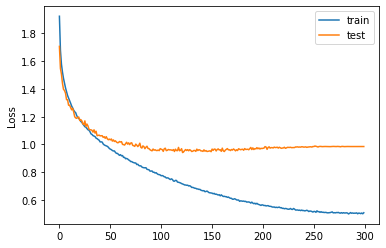

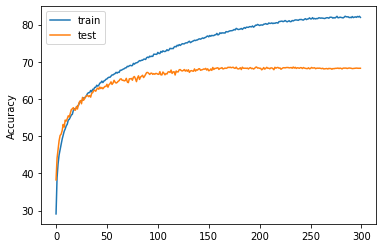


                                Experimenting on cifar10 Dataset 
                                patch:8,
                                sparse_att: False,
                                sparse_mlp: True,
                                num_layers: 4,
                                pos_embed: False,
                                seed: 147
                            
Files already downloaded and verified
Files already downloaded and verified
16 256
ViT Mixer : Channels per patch -> Initial:192 Final:256
[2, 4, 8, 16, 32, 64, 128, 256]
Sequence len: 16 ; Block size: 16
Channel dim: 256 num heads: 16
MLP dim: 256 ; Block size: 16
number of params:  1284362
Model Name: 01.3_ViT_nPE_cifar10_patch8_l4_att_sMlp_s147


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 0 Loss: 1.847 | Acc: 32.048 16024/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.86it/s]


[Test] 0 Loss: 1.623 | Acc: 41.430 4143/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.53it/s]


[Train] 1 Loss: 1.602 | Acc: 41.454 20727/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.28it/s]


[Test] 1 Loss: 1.528 | Acc: 45.470 4547/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.61it/s]


[Train] 2 Loss: 1.524 | Acc: 44.390 22195/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.14it/s]


[Test] 2 Loss: 1.472 | Acc: 47.190 4719/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.56it/s]


[Train] 3 Loss: 1.469 | Acc: 46.628 23314/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.17it/s]


[Test] 3 Loss: 1.431 | Acc: 49.470 4947/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.71it/s]


[Train] 4 Loss: 1.430 | Acc: 48.268 24134/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.48it/s]


[Test] 4 Loss: 1.371 | Acc: 51.560 5156/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.87it/s]


[Train] 5 Loss: 1.400 | Acc: 49.628 24814/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.20it/s]


[Test] 5 Loss: 1.361 | Acc: 51.870 5187/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.43it/s]


[Train] 6 Loss: 1.364 | Acc: 50.594 25297/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.95it/s]


[Test] 6 Loss: 1.338 | Acc: 52.750 5275/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.76it/s]


[Train] 7 Loss: 1.335 | Acc: 51.766 25883/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.46it/s]


[Test] 7 Loss: 1.288 | Acc: 54.150 5415/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.32it/s]


[Train] 8 Loss: 1.309 | Acc: 52.870 26435/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.13it/s]


[Test] 8 Loss: 1.285 | Acc: 54.130 5413/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.38it/s]


[Train] 9 Loss: 1.298 | Acc: 53.286 26643/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.14it/s]


[Test] 9 Loss: 1.248 | Acc: 55.850 5585/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.63it/s]


[Train] 10 Loss: 1.275 | Acc: 54.160 27080/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.42it/s]


[Test] 10 Loss: 1.246 | Acc: 55.860 5586/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.25it/s]


[Train] 11 Loss: 1.257 | Acc: 55.038 27519/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.78it/s]


[Test] 11 Loss: 1.249 | Acc: 55.590 5559/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.65it/s]


[Train] 12 Loss: 1.240 | Acc: 55.532 27766/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.97it/s]


[Test] 12 Loss: 1.211 | Acc: 57.080 5708/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.62it/s]


[Train] 13 Loss: 1.223 | Acc: 56.008 28004/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.46it/s]


[Test] 13 Loss: 1.226 | Acc: 56.430 5643/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 14 Loss: 1.208 | Acc: 56.794 28397/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.07it/s]


[Test] 14 Loss: 1.196 | Acc: 57.440 5744/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 15 Loss: 1.194 | Acc: 57.248 28624/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.20it/s]


[Test] 15 Loss: 1.160 | Acc: 58.900 5890/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 16 Loss: 1.182 | Acc: 57.688 28844/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.22it/s]


[Test] 16 Loss: 1.160 | Acc: 58.920 5892/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.68it/s]


[Train] 17 Loss: 1.168 | Acc: 58.368 29184/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.24it/s]


[Test] 17 Loss: 1.148 | Acc: 58.680 5868/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.89it/s]


[Train] 18 Loss: 1.155 | Acc: 58.782 29391/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.78it/s]


[Test] 18 Loss: 1.140 | Acc: 59.400 5940/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.65it/s]


[Train] 19 Loss: 1.145 | Acc: 58.934 29467/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.80it/s]


[Test] 19 Loss: 1.165 | Acc: 57.960 5796/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.50it/s]


[Train] 20 Loss: 1.138 | Acc: 59.478 29739/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.10it/s]


[Test] 20 Loss: 1.136 | Acc: 59.270 5927/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.39it/s]


[Train] 21 Loss: 1.129 | Acc: 59.646 29823/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.66it/s]


[Test] 21 Loss: 1.123 | Acc: 59.730 5973/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.49it/s]


[Train] 22 Loss: 1.118 | Acc: 60.142 30071/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.45it/s]


[Test] 22 Loss: 1.112 | Acc: 60.180 6018/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.58it/s]


[Train] 23 Loss: 1.109 | Acc: 60.486 30243/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.66it/s]


[Test] 23 Loss: 1.101 | Acc: 60.820 6082/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.69it/s]


[Train] 24 Loss: 1.098 | Acc: 60.870 30435/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.76it/s]


[Test] 24 Loss: 1.097 | Acc: 60.720 6072/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.53it/s]


[Train] 25 Loss: 1.089 | Acc: 61.144 30572/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.10it/s]


[Test] 25 Loss: 1.112 | Acc: 60.350 6035/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.35it/s]


[Train] 26 Loss: 1.081 | Acc: 61.446 30723/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.20it/s]


[Test] 26 Loss: 1.074 | Acc: 61.820 6182/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.53it/s]


[Train] 27 Loss: 1.076 | Acc: 61.550 30775/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.97it/s]


[Test] 27 Loss: 1.071 | Acc: 61.920 6192/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.36it/s]


[Train] 28 Loss: 1.066 | Acc: 61.834 30917/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.38it/s]


[Test] 28 Loss: 1.088 | Acc: 61.110 6111/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.52it/s]


[Train] 29 Loss: 1.059 | Acc: 61.910 30955/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.45it/s]


[Test] 29 Loss: 1.067 | Acc: 61.990 6199/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.73it/s]


[Train] 30 Loss: 1.048 | Acc: 62.540 31270/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.46it/s]


[Test] 30 Loss: 1.065 | Acc: 62.100 6210/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.93it/s]


[Train] 31 Loss: 1.039 | Acc: 62.956 31478/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.17it/s]


[Test] 31 Loss: 1.052 | Acc: 62.660 6266/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.39it/s]


[Train] 32 Loss: 1.036 | Acc: 62.942 31471/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.39it/s]


[Test] 32 Loss: 1.046 | Acc: 62.560 6256/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.55it/s]


[Train] 33 Loss: 1.027 | Acc: 63.298 31649/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.50it/s]


[Test] 33 Loss: 1.046 | Acc: 62.970 6297/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.89it/s]


[Train] 34 Loss: 1.021 | Acc: 63.710 31855/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.58it/s]


[Test] 34 Loss: 1.063 | Acc: 61.990 6199/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.51it/s]


[Train] 35 Loss: 1.015 | Acc: 63.712 31856/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.17it/s]


[Test] 35 Loss: 1.014 | Acc: 63.610 6361/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.52it/s]


[Train] 36 Loss: 1.007 | Acc: 64.028 32014/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.95it/s]


[Test] 36 Loss: 1.015 | Acc: 63.900 6390/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.39it/s]


[Train] 37 Loss: 1.005 | Acc: 64.278 32139/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.81it/s]


[Test] 37 Loss: 0.999 | Acc: 64.210 6421/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.39it/s]


[Train] 38 Loss: 0.989 | Acc: 64.550 32275/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.69it/s]


[Test] 38 Loss: 1.011 | Acc: 63.950 6395/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.26it/s]


[Train] 39 Loss: 0.989 | Acc: 64.732 32366/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.97it/s]


[Test] 39 Loss: 1.003 | Acc: 64.430 6443/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 40 Loss: 0.978 | Acc: 65.040 32520/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.99it/s]


[Test] 40 Loss: 1.003 | Acc: 64.650 6465/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.56it/s]


[Train] 41 Loss: 0.977 | Acc: 65.236 32618/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.83it/s]


[Test] 41 Loss: 0.991 | Acc: 64.650 6465/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.61it/s]


[Train] 42 Loss: 0.964 | Acc: 65.688 32844/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.85it/s]


[Test] 42 Loss: 0.995 | Acc: 64.300 6430/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.63it/s]


[Train] 43 Loss: 0.964 | Acc: 65.704 32852/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.10it/s]


[Test] 43 Loss: 0.999 | Acc: 64.500 6450/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.80it/s]


[Train] 44 Loss: 0.959 | Acc: 65.604 32802/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.67it/s]


[Test] 44 Loss: 0.979 | Acc: 64.910 6491/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.72it/s]


[Train] 45 Loss: 0.955 | Acc: 65.972 32986/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.65it/s]


[Test] 45 Loss: 0.971 | Acc: 65.080 6508/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.63it/s]


[Train] 46 Loss: 0.949 | Acc: 66.128 33064/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.75it/s]


[Test] 46 Loss: 0.986 | Acc: 64.920 6492/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.43it/s]


[Train] 47 Loss: 0.944 | Acc: 66.270 33135/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.40it/s]


[Test] 47 Loss: 0.980 | Acc: 65.070 6507/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.64it/s]


[Train] 48 Loss: 0.935 | Acc: 66.570 33285/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.63it/s]


[Test] 48 Loss: 0.974 | Acc: 65.510 6551/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.57it/s]


[Train] 49 Loss: 0.931 | Acc: 66.828 33414/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.90it/s]


[Test] 49 Loss: 0.968 | Acc: 65.320 6532/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.49it/s]


[Train] 50 Loss: 0.924 | Acc: 67.162 33581/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.74it/s]


[Test] 50 Loss: 0.969 | Acc: 65.740 6574/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.45it/s]


[Train] 51 Loss: 0.923 | Acc: 66.912 33456/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.65it/s]


[Test] 51 Loss: 0.970 | Acc: 65.210 6521/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.68it/s]


[Train] 52 Loss: 0.916 | Acc: 67.444 33722/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.30it/s]


[Test] 52 Loss: 0.972 | Acc: 65.680 6568/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.54it/s]


[Train] 53 Loss: 0.915 | Acc: 67.372 33686/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.80it/s]


[Test] 53 Loss: 0.960 | Acc: 65.600 6560/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.56it/s]


[Train] 54 Loss: 0.913 | Acc: 67.500 33750/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.60it/s]


[Test] 54 Loss: 0.966 | Acc: 65.850 6585/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.55it/s]


[Train] 55 Loss: 0.903 | Acc: 67.702 33851/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.39it/s]


[Test] 55 Loss: 0.959 | Acc: 65.830 6583/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.25it/s]


[Train] 56 Loss: 0.900 | Acc: 68.116 34058/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.64it/s]


[Test] 56 Loss: 0.956 | Acc: 66.040 6604/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.85it/s]


[Train] 57 Loss: 0.894 | Acc: 67.986 33993/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.10it/s]


[Test] 57 Loss: 0.949 | Acc: 66.550 6655/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.60it/s]


[Train] 58 Loss: 0.887 | Acc: 68.442 34221/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.09it/s]


[Test] 58 Loss: 0.957 | Acc: 66.280 6628/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.49it/s]


[Train] 59 Loss: 0.885 | Acc: 68.364 34182/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.49it/s]


[Test] 59 Loss: 0.942 | Acc: 66.340 6634/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.58it/s]


[Train] 60 Loss: 0.885 | Acc: 68.554 34277/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.72it/s]


[Test] 60 Loss: 0.937 | Acc: 66.710 6671/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.69it/s]


[Train] 61 Loss: 0.877 | Acc: 68.738 34369/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.99it/s]


[Test] 61 Loss: 0.941 | Acc: 66.670 6667/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.16it/s]


[Train] 62 Loss: 0.870 | Acc: 69.134 34567/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.85it/s]


[Test] 62 Loss: 0.947 | Acc: 66.460 6646/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.63it/s]


[Train] 63 Loss: 0.864 | Acc: 69.190 34595/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.66it/s]


[Test] 63 Loss: 0.934 | Acc: 67.000 6700/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.78it/s]


[Train] 64 Loss: 0.866 | Acc: 69.168 34584/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.34it/s]


[Test] 64 Loss: 0.927 | Acc: 67.440 6744/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.34it/s]


[Train] 65 Loss: 0.856 | Acc: 69.380 34690/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.41it/s]


[Test] 65 Loss: 0.932 | Acc: 66.980 6698/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.34it/s]


[Train] 66 Loss: 0.853 | Acc: 69.696 34848/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.87it/s]


[Test] 66 Loss: 0.949 | Acc: 66.880 6688/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.43it/s]


[Train] 67 Loss: 0.851 | Acc: 69.664 34832/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.25it/s]


[Test] 67 Loss: 0.935 | Acc: 66.870 6687/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.06it/s]


[Train] 68 Loss: 0.851 | Acc: 69.762 34881/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.03it/s]


[Test] 68 Loss: 0.934 | Acc: 67.140 6714/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.62it/s]


[Train] 69 Loss: 0.838 | Acc: 70.114 35057/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.66it/s]


[Test] 69 Loss: 0.945 | Acc: 66.710 6671/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.87it/s]


[Train] 70 Loss: 0.834 | Acc: 70.296 35148/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.00it/s]


[Test] 70 Loss: 0.945 | Acc: 66.550 6655/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.65it/s]


[Train] 71 Loss: 0.835 | Acc: 70.116 35058/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.60it/s]


[Test] 71 Loss: 0.929 | Acc: 67.800 6780/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.52it/s]


[Train] 72 Loss: 0.825 | Acc: 70.518 35259/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.87it/s]


[Test] 72 Loss: 0.934 | Acc: 67.430 6743/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.72it/s]


[Train] 73 Loss: 0.826 | Acc: 70.530 35265/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.92it/s]


[Test] 73 Loss: 0.910 | Acc: 67.990 6799/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.36it/s]


[Train] 74 Loss: 0.823 | Acc: 70.660 35330/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.84it/s]


[Test] 74 Loss: 0.905 | Acc: 67.480 6748/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.25it/s]


[Train] 75 Loss: 0.825 | Acc: 70.658 35329/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.96it/s]


[Test] 75 Loss: 0.913 | Acc: 68.160 6816/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.59it/s]


[Train] 76 Loss: 0.814 | Acc: 70.946 35473/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.09it/s]


[Test] 76 Loss: 0.939 | Acc: 67.140 6714/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.32it/s]


[Train] 77 Loss: 0.815 | Acc: 71.168 35584/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.17it/s]


[Test] 77 Loss: 0.896 | Acc: 68.410 6841/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.48it/s]


[Train] 78 Loss: 0.812 | Acc: 71.310 35655/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.75it/s]


[Test] 78 Loss: 0.919 | Acc: 67.590 6759/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.64it/s]


[Train] 79 Loss: 0.805 | Acc: 71.300 35650/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.02it/s]


[Test] 79 Loss: 0.921 | Acc: 67.290 6729/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.48it/s]


[Train] 80 Loss: 0.804 | Acc: 71.298 35649/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.24it/s]


[Test] 80 Loss: 0.909 | Acc: 68.180 6818/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.78it/s]


[Train] 81 Loss: 0.798 | Acc: 71.528 35764/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.93it/s]


[Test] 81 Loss: 0.901 | Acc: 68.160 6816/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.37it/s]


[Train] 82 Loss: 0.792 | Acc: 71.904 35952/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.57it/s]


[Test] 82 Loss: 0.911 | Acc: 68.070 6807/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.55it/s]


[Train] 83 Loss: 0.790 | Acc: 71.816 35908/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.48it/s]


[Test] 83 Loss: 0.916 | Acc: 67.970 6797/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.57it/s]


[Train] 84 Loss: 0.787 | Acc: 71.812 35906/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.04it/s]


[Test] 84 Loss: 0.900 | Acc: 68.300 6830/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.37it/s]


[Train] 85 Loss: 0.785 | Acc: 71.922 35961/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.85it/s]


[Test] 85 Loss: 0.895 | Acc: 68.330 6833/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.21it/s]


[Train] 86 Loss: 0.780 | Acc: 72.206 36103/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.04it/s]


[Test] 86 Loss: 0.904 | Acc: 68.170 6817/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.72it/s]


[Train] 87 Loss: 0.773 | Acc: 72.626 36313/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.85it/s]


[Test] 87 Loss: 0.906 | Acc: 68.230 6823/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.29it/s]


[Train] 88 Loss: 0.773 | Acc: 72.394 36197/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.29it/s]


[Test] 88 Loss: 0.902 | Acc: 68.430 6843/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.46it/s]


[Train] 89 Loss: 0.767 | Acc: 72.564 36282/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.60it/s]


[Test] 89 Loss: 0.893 | Acc: 68.860 6886/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.69it/s]


[Train] 90 Loss: 0.767 | Acc: 72.564 36282/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.90it/s]


[Test] 90 Loss: 0.895 | Acc: 69.040 6904/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.30it/s]


[Train] 91 Loss: 0.766 | Acc: 72.708 36354/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.44it/s]


[Test] 91 Loss: 0.896 | Acc: 68.640 6864/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.58it/s]


[Train] 92 Loss: 0.758 | Acc: 72.964 36482/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.28it/s]


[Test] 92 Loss: 0.910 | Acc: 68.200 6820/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.88it/s]


[Train] 93 Loss: 0.760 | Acc: 72.892 36446/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.67it/s]


[Test] 93 Loss: 0.894 | Acc: 68.980 6898/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.64it/s]


[Train] 94 Loss: 0.754 | Acc: 73.078 36539/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.29it/s]


[Test] 94 Loss: 0.890 | Acc: 68.700 6870/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.31it/s]


[Train] 95 Loss: 0.754 | Acc: 73.006 36503/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.12it/s]


[Test] 95 Loss: 0.885 | Acc: 69.330 6933/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.48it/s]


[Train] 96 Loss: 0.748 | Acc: 73.332 36666/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.22it/s]


[Test] 96 Loss: 0.880 | Acc: 69.210 6921/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.66it/s]


[Train] 97 Loss: 0.748 | Acc: 73.250 36625/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.38it/s]


[Test] 97 Loss: 0.889 | Acc: 68.920 6892/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.61it/s]


[Train] 98 Loss: 0.738 | Acc: 73.654 36827/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.44it/s]


[Test] 98 Loss: 0.882 | Acc: 69.260 6926/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.46it/s]


[Train] 99 Loss: 0.742 | Acc: 73.456 36728/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.81it/s]


[Test] 99 Loss: 0.890 | Acc: 69.100 6910/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.53it/s]


[Train] 100 Loss: 0.735 | Acc: 73.786 36893/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.26it/s]


[Test] 100 Loss: 0.884 | Acc: 69.510 6951/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.33it/s]


[Train] 101 Loss: 0.735 | Acc: 73.710 36855/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.16it/s]


[Test] 101 Loss: 0.891 | Acc: 69.170 6917/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.73it/s]


[Train] 102 Loss: 0.731 | Acc: 73.650 36825/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.07it/s]


[Test] 102 Loss: 0.884 | Acc: 69.600 6960/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.40it/s]


[Train] 103 Loss: 0.726 | Acc: 73.910 36955/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.65it/s]


[Test] 103 Loss: 0.884 | Acc: 69.260 6926/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.46it/s]


[Train] 104 Loss: 0.731 | Acc: 73.810 36905/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.54it/s]


[Test] 104 Loss: 0.913 | Acc: 68.290 6829/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.57it/s]


[Train] 105 Loss: 0.719 | Acc: 74.306 37153/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.75it/s]


[Test] 105 Loss: 0.876 | Acc: 69.340 6934/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.66it/s]


[Train] 106 Loss: 0.722 | Acc: 74.176 37088/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.83it/s]


[Test] 106 Loss: 0.881 | Acc: 69.510 6951/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.61it/s]


[Train] 107 Loss: 0.717 | Acc: 74.416 37208/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.48it/s]


[Test] 107 Loss: 0.899 | Acc: 68.880 6888/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.80it/s]


[Train] 108 Loss: 0.719 | Acc: 74.190 37095/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.97it/s]


[Test] 108 Loss: 0.877 | Acc: 69.260 6926/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.63it/s]


[Train] 109 Loss: 0.709 | Acc: 74.618 37309/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.85it/s]


[Test] 109 Loss: 0.881 | Acc: 69.130 6913/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.57it/s]


[Train] 110 Loss: 0.709 | Acc: 74.744 37372/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.67it/s]


[Test] 110 Loss: 0.880 | Acc: 69.370 6937/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.40it/s]


[Train] 111 Loss: 0.705 | Acc: 74.804 37402/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.87it/s]


[Test] 111 Loss: 0.895 | Acc: 69.070 6907/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.48it/s]


[Train] 112 Loss: 0.700 | Acc: 74.974 37487/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.01it/s]


[Test] 112 Loss: 0.880 | Acc: 69.300 6930/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.56it/s]


[Train] 113 Loss: 0.699 | Acc: 75.236 37618/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.00it/s]


[Test] 113 Loss: 0.881 | Acc: 69.480 6948/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.57it/s]


[Train] 114 Loss: 0.696 | Acc: 75.076 37538/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.00it/s]


[Test] 114 Loss: 0.874 | Acc: 69.950 6995/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.35it/s]


[Train] 115 Loss: 0.695 | Acc: 75.160 37580/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.49it/s]


[Test] 115 Loss: 0.889 | Acc: 69.230 6923/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.31it/s]


[Train] 116 Loss: 0.695 | Acc: 74.996 37498/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.82it/s]


[Test] 116 Loss: 0.874 | Acc: 69.630 6963/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.86it/s]


[Train] 117 Loss: 0.693 | Acc: 75.250 37625/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.59it/s]


[Test] 117 Loss: 0.891 | Acc: 69.840 6984/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.64it/s]


[Train] 118 Loss: 0.689 | Acc: 75.358 37679/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.72it/s]


[Test] 118 Loss: 0.900 | Acc: 68.790 6879/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.90it/s]


[Train] 119 Loss: 0.685 | Acc: 75.572 37786/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.51it/s]


[Test] 119 Loss: 0.871 | Acc: 70.170 7017/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.56it/s]


[Train] 120 Loss: 0.683 | Acc: 75.554 37777/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.58it/s]


[Test] 120 Loss: 0.877 | Acc: 69.670 6967/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.49it/s]


[Train] 121 Loss: 0.681 | Acc: 75.804 37902/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.82it/s]


[Test] 121 Loss: 0.884 | Acc: 69.810 6981/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.54it/s]


[Train] 122 Loss: 0.674 | Acc: 75.928 37964/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.77it/s]


[Test] 122 Loss: 0.886 | Acc: 69.680 6968/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.30it/s]


[Train] 123 Loss: 0.674 | Acc: 75.916 37958/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.86it/s]


[Test] 123 Loss: 0.873 | Acc: 69.950 6995/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.67it/s]


[Train] 124 Loss: 0.667 | Acc: 75.990 37995/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.34it/s]


[Test] 124 Loss: 0.883 | Acc: 69.740 6974/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.37it/s]


[Train] 125 Loss: 0.667 | Acc: 76.150 38075/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.21it/s]


[Test] 125 Loss: 0.876 | Acc: 70.140 7014/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.51it/s]


[Train] 126 Loss: 0.667 | Acc: 76.038 38019/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.82it/s]


[Test] 126 Loss: 0.873 | Acc: 69.980 6998/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.64it/s]


[Train] 127 Loss: 0.665 | Acc: 76.140 38070/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.18it/s]


[Test] 127 Loss: 0.873 | Acc: 70.140 7014/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.49it/s]


[Train] 128 Loss: 0.663 | Acc: 76.332 38166/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.18it/s]


[Test] 128 Loss: 0.876 | Acc: 69.620 6962/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.77it/s]


[Train] 129 Loss: 0.659 | Acc: 76.388 38194/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.36it/s]


[Test] 129 Loss: 0.879 | Acc: 70.030 7003/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.62it/s]


[Train] 130 Loss: 0.652 | Acc: 76.816 38408/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.12it/s]


[Test] 130 Loss: 0.871 | Acc: 70.290 7029/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.71it/s]


[Train] 131 Loss: 0.656 | Acc: 76.516 38258/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.90it/s]


[Test] 131 Loss: 0.881 | Acc: 70.090 7009/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.72it/s]


[Train] 132 Loss: 0.654 | Acc: 76.490 38245/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.77it/s]


[Test] 132 Loss: 0.871 | Acc: 70.450 7045/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.45it/s]


[Train] 133 Loss: 0.652 | Acc: 76.604 38302/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.79it/s]


[Test] 133 Loss: 0.872 | Acc: 70.130 7013/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.79it/s]


[Train] 134 Loss: 0.647 | Acc: 77.050 38525/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.75it/s]


[Test] 134 Loss: 0.873 | Acc: 70.310 7031/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.73it/s]


[Train] 135 Loss: 0.647 | Acc: 76.986 38493/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.98it/s]


[Test] 135 Loss: 0.879 | Acc: 69.810 6981/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.50it/s]


[Train] 136 Loss: 0.641 | Acc: 77.052 38526/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.52it/s]


[Test] 136 Loss: 0.885 | Acc: 70.050 7005/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.54it/s]


[Train] 137 Loss: 0.635 | Acc: 77.368 38684/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.66it/s]


[Test] 137 Loss: 0.879 | Acc: 70.180 7018/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.44it/s]


[Train] 138 Loss: 0.641 | Acc: 76.926 38463/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.59it/s]


[Test] 138 Loss: 0.874 | Acc: 70.190 7019/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.39it/s]


[Train] 139 Loss: 0.639 | Acc: 77.212 38606/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.04it/s]


[Test] 139 Loss: 0.882 | Acc: 70.530 7053/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.41it/s]


[Train] 140 Loss: 0.633 | Acc: 77.260 38630/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.61it/s]


[Test] 140 Loss: 0.869 | Acc: 70.390 7039/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.67it/s]


[Train] 141 Loss: 0.631 | Acc: 77.610 38805/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.96it/s]


[Test] 141 Loss: 0.865 | Acc: 70.840 7084/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.32it/s]


[Train] 142 Loss: 0.631 | Acc: 77.556 38778/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.43it/s]


[Test] 142 Loss: 0.876 | Acc: 70.280 7028/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.40it/s]


[Train] 143 Loss: 0.623 | Acc: 77.748 38874/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.28it/s]


[Test] 143 Loss: 0.867 | Acc: 70.830 7083/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.36it/s]


[Train] 144 Loss: 0.626 | Acc: 77.618 38809/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.85it/s]


[Test] 144 Loss: 0.873 | Acc: 70.420 7042/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.35it/s]


[Train] 145 Loss: 0.628 | Acc: 77.720 38860/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.41it/s]


[Test] 145 Loss: 0.868 | Acc: 70.820 7082/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.86it/s]


[Train] 146 Loss: 0.620 | Acc: 77.664 38832/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.14it/s]


[Test] 146 Loss: 0.878 | Acc: 70.290 7029/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.29it/s]


[Train] 147 Loss: 0.616 | Acc: 77.770 38885/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.27it/s]


[Test] 147 Loss: 0.870 | Acc: 70.820 7082/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.23it/s]


[Train] 148 Loss: 0.616 | Acc: 78.010 39005/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.49it/s]


[Test] 148 Loss: 0.873 | Acc: 70.680 7068/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.73it/s]


[Train] 149 Loss: 0.613 | Acc: 78.242 39121/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.48it/s]


[Test] 149 Loss: 0.876 | Acc: 70.450 7045/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.34it/s]


[Train] 150 Loss: 0.621 | Acc: 77.680 38840/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.42it/s]


[Test] 150 Loss: 0.879 | Acc: 70.210 7021/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.54it/s]


[Train] 151 Loss: 0.616 | Acc: 77.768 38884/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.98it/s]


[Test] 151 Loss: 0.867 | Acc: 70.910 7091/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.55it/s]


[Train] 152 Loss: 0.611 | Acc: 78.230 39115/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.61it/s]


[Test] 152 Loss: 0.867 | Acc: 70.800 7080/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.50it/s]


[Train] 153 Loss: 0.611 | Acc: 78.300 39150/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.65it/s]


[Test] 153 Loss: 0.857 | Acc: 70.900 7090/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.54it/s]


[Train] 154 Loss: 0.604 | Acc: 78.200 39100/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.74it/s]


[Test] 154 Loss: 0.868 | Acc: 71.100 7110/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.45it/s]


[Train] 155 Loss: 0.606 | Acc: 78.354 39177/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.52it/s]


[Test] 155 Loss: 0.868 | Acc: 70.610 7061/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.21it/s]


[Train] 156 Loss: 0.604 | Acc: 78.270 39135/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.04it/s]


[Test] 156 Loss: 0.871 | Acc: 70.690 7069/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.75it/s]


[Train] 157 Loss: 0.603 | Acc: 78.532 39266/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.69it/s]


[Test] 157 Loss: 0.873 | Acc: 70.500 7050/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.57it/s]


[Train] 158 Loss: 0.597 | Acc: 78.558 39279/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.37it/s]


[Test] 158 Loss: 0.866 | Acc: 70.830 7083/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.82it/s]


[Train] 159 Loss: 0.600 | Acc: 78.502 39251/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.59it/s]


[Test] 159 Loss: 0.867 | Acc: 70.640 7064/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.65it/s]


[Train] 160 Loss: 0.597 | Acc: 78.580 39290/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.67it/s]


[Test] 160 Loss: 0.879 | Acc: 70.440 7044/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.63it/s]


[Train] 161 Loss: 0.588 | Acc: 78.824 39412/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.30it/s]


[Test] 161 Loss: 0.873 | Acc: 70.330 7033/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.78it/s]


[Train] 162 Loss: 0.591 | Acc: 78.886 39443/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.09it/s]


[Test] 162 Loss: 0.864 | Acc: 71.090 7109/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.55it/s]


[Train] 163 Loss: 0.589 | Acc: 78.994 39497/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.11it/s]


[Test] 163 Loss: 0.872 | Acc: 70.720 7072/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.62it/s]


[Train] 164 Loss: 0.589 | Acc: 78.924 39462/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.95it/s]


[Test] 164 Loss: 0.866 | Acc: 71.000 7100/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.42it/s]


[Train] 165 Loss: 0.588 | Acc: 78.828 39414/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.82it/s]


[Test] 165 Loss: 0.881 | Acc: 70.700 7070/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.61it/s]


[Train] 166 Loss: 0.589 | Acc: 78.966 39483/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.98it/s]


[Test] 166 Loss: 0.869 | Acc: 71.300 7130/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.48it/s]


[Train] 167 Loss: 0.581 | Acc: 79.124 39562/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.94it/s]


[Test] 167 Loss: 0.878 | Acc: 70.850 7085/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.14it/s]


[Train] 168 Loss: 0.581 | Acc: 79.032 39516/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.68it/s]


[Test] 168 Loss: 0.875 | Acc: 71.020 7102/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.66it/s]


[Train] 169 Loss: 0.578 | Acc: 79.276 39638/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.11it/s]


[Test] 169 Loss: 0.871 | Acc: 70.810 7081/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 170 Loss: 0.577 | Acc: 79.252 39626/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.90it/s]


[Test] 170 Loss: 0.884 | Acc: 70.730 7073/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.83it/s]


[Train] 171 Loss: 0.568 | Acc: 79.704 39852/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.30it/s]


[Test] 171 Loss: 0.873 | Acc: 70.870 7087/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.78it/s]


[Train] 172 Loss: 0.573 | Acc: 79.668 39834/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.27it/s]


[Test] 172 Loss: 0.876 | Acc: 71.140 7114/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.33it/s]


[Train] 173 Loss: 0.571 | Acc: 79.494 39747/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.79it/s]


[Test] 173 Loss: 0.874 | Acc: 70.980 7098/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.54it/s]


[Train] 174 Loss: 0.568 | Acc: 79.610 39805/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.31it/s]


[Test] 174 Loss: 0.878 | Acc: 70.710 7071/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.54it/s]


[Train] 175 Loss: 0.570 | Acc: 79.610 39805/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.23it/s]


[Test] 175 Loss: 0.876 | Acc: 70.620 7062/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.33it/s]


[Train] 176 Loss: 0.568 | Acc: 79.844 39922/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.69it/s]


[Test] 176 Loss: 0.884 | Acc: 70.440 7044/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.51it/s]


[Train] 177 Loss: 0.561 | Acc: 79.908 39954/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.04it/s]


[Test] 177 Loss: 0.873 | Acc: 70.940 7094/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.57it/s]


[Train] 178 Loss: 0.566 | Acc: 79.842 39921/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.32it/s]


[Test] 178 Loss: 0.875 | Acc: 71.170 7117/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.57it/s]


[Train] 179 Loss: 0.560 | Acc: 79.714 39857/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.31it/s]


[Test] 179 Loss: 0.875 | Acc: 70.900 7090/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.66it/s]


[Train] 180 Loss: 0.557 | Acc: 80.070 40035/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.14it/s]


[Test] 180 Loss: 0.873 | Acc: 70.760 7076/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.57it/s]


[Train] 181 Loss: 0.562 | Acc: 79.664 39832/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.64it/s]


[Test] 181 Loss: 0.872 | Acc: 71.020 7102/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.51it/s]


[Train] 182 Loss: 0.556 | Acc: 80.160 40080/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.83it/s]


[Test] 182 Loss: 0.874 | Acc: 71.130 7113/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.74it/s]


[Train] 183 Loss: 0.559 | Acc: 80.048 40024/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.45it/s]


[Test] 183 Loss: 0.879 | Acc: 70.910 7091/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.91it/s]


[Train] 184 Loss: 0.553 | Acc: 80.044 40022/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.31it/s]


[Test] 184 Loss: 0.881 | Acc: 70.940 7094/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.52it/s]


[Train] 185 Loss: 0.555 | Acc: 80.036 40018/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.26it/s]


[Test] 185 Loss: 0.879 | Acc: 70.660 7066/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.35it/s]


[Train] 186 Loss: 0.553 | Acc: 80.260 40130/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.71it/s]


[Test] 186 Loss: 0.882 | Acc: 70.840 7084/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.56it/s]


[Train] 187 Loss: 0.546 | Acc: 80.492 40246/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.27it/s]


[Test] 187 Loss: 0.878 | Acc: 70.880 7088/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 188 Loss: 0.545 | Acc: 80.666 40333/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.13it/s]


[Test] 188 Loss: 0.877 | Acc: 70.960 7096/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 189 Loss: 0.554 | Acc: 80.118 40059/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.45it/s]


[Test] 189 Loss: 0.874 | Acc: 70.730 7073/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.57it/s]


[Train] 190 Loss: 0.547 | Acc: 80.654 40327/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.12it/s]


[Test] 190 Loss: 0.872 | Acc: 71.240 7124/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.61it/s]


[Train] 191 Loss: 0.543 | Acc: 80.428 40214/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.18it/s]


[Test] 191 Loss: 0.874 | Acc: 70.980 7098/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.43it/s]


[Train] 192 Loss: 0.536 | Acc: 80.978 40489/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.17it/s]


[Test] 192 Loss: 0.877 | Acc: 70.940 7094/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.48it/s]


[Train] 193 Loss: 0.545 | Acc: 80.332 40166/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.42it/s]


[Test] 193 Loss: 0.879 | Acc: 71.200 7120/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.52it/s]


[Train] 194 Loss: 0.540 | Acc: 80.630 40315/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.29it/s]


[Test] 194 Loss: 0.878 | Acc: 71.110 7111/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.52it/s]


[Train] 195 Loss: 0.543 | Acc: 80.646 40323/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.98it/s]


[Test] 195 Loss: 0.874 | Acc: 71.100 7110/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.62it/s]


[Train] 196 Loss: 0.540 | Acc: 80.648 40324/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.12it/s]


[Test] 196 Loss: 0.879 | Acc: 71.110 7111/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.92it/s]


[Train] 197 Loss: 0.533 | Acc: 80.870 40435/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.37it/s]


[Test] 197 Loss: 0.880 | Acc: 71.140 7114/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.79it/s]


[Train] 198 Loss: 0.535 | Acc: 80.898 40449/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.29it/s]


[Test] 198 Loss: 0.876 | Acc: 70.900 7090/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 199 Loss: 0.532 | Acc: 80.936 40468/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.11it/s]


[Test] 199 Loss: 0.876 | Acc: 70.940 7094/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.62it/s]


[Train] 200 Loss: 0.533 | Acc: 81.006 40503/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.08it/s]


[Test] 200 Loss: 0.883 | Acc: 70.980 7098/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.53it/s]


[Train] 201 Loss: 0.530 | Acc: 81.166 40583/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.24it/s]


[Test] 201 Loss: 0.879 | Acc: 70.930 7093/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.35it/s]


[Train] 202 Loss: 0.533 | Acc: 80.966 40483/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.69it/s]


[Test] 202 Loss: 0.883 | Acc: 70.820 7082/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.64it/s]


[Train] 203 Loss: 0.527 | Acc: 81.084 40542/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.41it/s]


[Test] 203 Loss: 0.878 | Acc: 71.120 7112/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.48it/s]


[Train] 204 Loss: 0.524 | Acc: 81.370 40685/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.69it/s]


[Test] 204 Loss: 0.880 | Acc: 71.100 7110/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.58it/s]


[Train] 205 Loss: 0.525 | Acc: 81.340 40670/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.27it/s]


[Test] 205 Loss: 0.884 | Acc: 71.090 7109/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.37it/s]


[Train] 206 Loss: 0.525 | Acc: 81.090 40545/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.01it/s]


[Test] 206 Loss: 0.885 | Acc: 70.720 7072/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.40it/s]


[Train] 207 Loss: 0.523 | Acc: 81.416 40708/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.02it/s]


[Test] 207 Loss: 0.880 | Acc: 71.050 7105/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.54it/s]


[Train] 208 Loss: 0.523 | Acc: 81.348 40674/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.41it/s]


[Test] 208 Loss: 0.886 | Acc: 71.140 7114/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.61it/s]


[Train] 209 Loss: 0.519 | Acc: 81.494 40747/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.97it/s]


[Test] 209 Loss: 0.883 | Acc: 71.070 7107/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.83it/s]


[Train] 210 Loss: 0.523 | Acc: 81.416 40708/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.46it/s]


[Test] 210 Loss: 0.884 | Acc: 71.040 7104/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.52it/s]


[Train] 211 Loss: 0.518 | Acc: 81.458 40729/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.35it/s]


[Test] 211 Loss: 0.886 | Acc: 71.000 7100/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.65it/s]


[Train] 212 Loss: 0.517 | Acc: 81.490 40745/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.56it/s]


[Test] 212 Loss: 0.892 | Acc: 71.170 7117/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.42it/s]


[Train] 213 Loss: 0.522 | Acc: 81.348 40674/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.33it/s]


[Test] 213 Loss: 0.890 | Acc: 70.940 7094/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.64it/s]


[Train] 214 Loss: 0.516 | Acc: 81.428 40714/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.56it/s]


[Test] 214 Loss: 0.887 | Acc: 70.950 7095/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.53it/s]


[Train] 215 Loss: 0.517 | Acc: 81.414 40707/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.35it/s]


[Test] 215 Loss: 0.885 | Acc: 71.230 7123/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.41it/s]


[Train] 216 Loss: 0.513 | Acc: 81.610 40805/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.84it/s]


[Test] 216 Loss: 0.883 | Acc: 71.210 7121/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.48it/s]


[Train] 217 Loss: 0.511 | Acc: 81.760 40880/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.48it/s]


[Test] 217 Loss: 0.882 | Acc: 71.400 7140/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.34it/s]


[Train] 218 Loss: 0.514 | Acc: 81.692 40846/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.89it/s]


[Test] 218 Loss: 0.883 | Acc: 71.320 7132/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.49it/s]


[Train] 219 Loss: 0.511 | Acc: 81.756 40878/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.23it/s]


[Test] 219 Loss: 0.877 | Acc: 71.440 7144/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.76it/s]


[Train] 220 Loss: 0.506 | Acc: 82.018 41009/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.52it/s]


[Test] 220 Loss: 0.886 | Acc: 71.190 7119/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.53it/s]


[Train] 221 Loss: 0.508 | Acc: 81.810 40905/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.76it/s]


[Test] 221 Loss: 0.884 | Acc: 71.340 7134/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.79it/s]


[Train] 222 Loss: 0.506 | Acc: 82.038 41019/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.29it/s]


[Test] 222 Loss: 0.883 | Acc: 71.220 7122/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.88it/s]


[Train] 223 Loss: 0.506 | Acc: 81.894 40947/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.49it/s]


[Test] 223 Loss: 0.888 | Acc: 71.430 7143/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.18it/s]


[Train] 224 Loss: 0.509 | Acc: 82.010 41005/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.66it/s]


[Test] 224 Loss: 0.886 | Acc: 71.250 7125/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.76it/s]


[Train] 225 Loss: 0.500 | Acc: 82.240 41120/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.25it/s]


[Test] 225 Loss: 0.884 | Acc: 71.450 7145/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.34it/s]


[Train] 226 Loss: 0.501 | Acc: 82.070 41035/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.32it/s]


[Test] 226 Loss: 0.887 | Acc: 71.290 7129/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.59it/s]


[Train] 227 Loss: 0.507 | Acc: 81.890 40945/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.98it/s]


[Test] 227 Loss: 0.887 | Acc: 71.050 7105/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.42it/s]


[Train] 228 Loss: 0.500 | Acc: 82.142 41071/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.75it/s]


[Test] 228 Loss: 0.885 | Acc: 71.170 7117/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.11it/s]


[Train] 229 Loss: 0.501 | Acc: 82.180 41090/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.27it/s]


[Test] 229 Loss: 0.883 | Acc: 70.930 7093/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.84it/s]


[Train] 230 Loss: 0.505 | Acc: 81.852 40926/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.35it/s]


[Test] 230 Loss: 0.884 | Acc: 71.270 7127/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.58it/s]


[Train] 231 Loss: 0.503 | Acc: 81.930 40965/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.10it/s]


[Test] 231 Loss: 0.881 | Acc: 71.440 7144/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.42it/s]


[Train] 232 Loss: 0.501 | Acc: 82.076 41038/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.72it/s]


[Test] 232 Loss: 0.883 | Acc: 71.020 7102/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.57it/s]


[Train] 233 Loss: 0.503 | Acc: 82.034 41017/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.45it/s]


[Test] 233 Loss: 0.885 | Acc: 71.160 7116/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.42it/s]


[Train] 234 Loss: 0.500 | Acc: 81.884 40942/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.93it/s]


[Test] 234 Loss: 0.885 | Acc: 71.460 7146/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.49it/s]


[Train] 235 Loss: 0.496 | Acc: 82.076 41038/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.36it/s]


[Test] 235 Loss: 0.883 | Acc: 71.270 7127/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.75it/s]


[Train] 236 Loss: 0.496 | Acc: 82.212 41106/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.88it/s]


[Test] 236 Loss: 0.881 | Acc: 71.540 7154/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.70it/s]


[Train] 237 Loss: 0.492 | Acc: 82.378 41189/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.41it/s]


[Test] 237 Loss: 0.884 | Acc: 71.330 7133/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.54it/s]


[Train] 238 Loss: 0.500 | Acc: 82.148 41074/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.75it/s]


[Test] 238 Loss: 0.886 | Acc: 71.390 7139/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.44it/s]


[Train] 239 Loss: 0.493 | Acc: 82.324 41162/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.51it/s]


[Test] 239 Loss: 0.885 | Acc: 71.290 7129/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.57it/s]


[Train] 240 Loss: 0.492 | Acc: 82.312 41156/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.98it/s]


[Test] 240 Loss: 0.883 | Acc: 71.470 7147/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.58it/s]


[Train] 241 Loss: 0.492 | Acc: 82.376 41188/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.03it/s]


[Test] 241 Loss: 0.887 | Acc: 71.240 7124/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.71it/s]


[Train] 242 Loss: 0.497 | Acc: 82.206 41103/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.94it/s]


[Test] 242 Loss: 0.883 | Acc: 71.440 7144/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.28it/s]


[Train] 243 Loss: 0.500 | Acc: 82.216 41108/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.82it/s]


[Test] 243 Loss: 0.882 | Acc: 71.570 7157/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.57it/s]


[Train] 244 Loss: 0.494 | Acc: 82.256 41128/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.40it/s]


[Test] 244 Loss: 0.883 | Acc: 71.510 7151/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.48it/s]


[Train] 245 Loss: 0.492 | Acc: 82.522 41261/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.96it/s]


[Test] 245 Loss: 0.882 | Acc: 71.160 7116/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.41it/s]


[Train] 246 Loss: 0.488 | Acc: 82.834 41417/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.31it/s]


[Test] 246 Loss: 0.882 | Acc: 71.500 7150/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.66it/s]


[Train] 247 Loss: 0.489 | Acc: 82.410 41205/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.26it/s]


[Test] 247 Loss: 0.883 | Acc: 71.600 7160/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.58it/s]


[Train] 248 Loss: 0.486 | Acc: 82.814 41407/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.89it/s]


[Test] 248 Loss: 0.886 | Acc: 71.440 7144/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.91it/s]


[Train] 249 Loss: 0.490 | Acc: 82.506 41253/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.38it/s]


[Test] 249 Loss: 0.888 | Acc: 71.490 7149/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.66it/s]


[Train] 250 Loss: 0.488 | Acc: 82.642 41321/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.01it/s]


[Test] 250 Loss: 0.885 | Acc: 71.430 7143/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.59it/s]


[Train] 251 Loss: 0.481 | Acc: 82.968 41484/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.66it/s]


[Test] 251 Loss: 0.886 | Acc: 71.570 7157/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.55it/s]


[Train] 252 Loss: 0.487 | Acc: 82.658 41329/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.29it/s]


[Test] 252 Loss: 0.885 | Acc: 71.420 7142/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.57it/s]


[Train] 253 Loss: 0.488 | Acc: 82.630 41315/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.95it/s]


[Test] 253 Loss: 0.885 | Acc: 71.530 7153/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.60it/s]


[Train] 254 Loss: 0.485 | Acc: 82.712 41356/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.70it/s]


[Test] 254 Loss: 0.884 | Acc: 71.650 7165/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 255 Loss: 0.485 | Acc: 82.666 41333/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.65it/s]


[Test] 255 Loss: 0.888 | Acc: 71.290 7129/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.31it/s]


[Train] 256 Loss: 0.485 | Acc: 82.578 41289/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.72it/s]


[Test] 256 Loss: 0.884 | Acc: 71.580 7158/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.50it/s]


[Train] 257 Loss: 0.485 | Acc: 82.650 41325/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.89it/s]


[Test] 257 Loss: 0.885 | Acc: 71.490 7149/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.36it/s]


[Train] 258 Loss: 0.483 | Acc: 82.710 41355/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.82it/s]


[Test] 258 Loss: 0.884 | Acc: 71.590 7159/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.69it/s]


[Train] 259 Loss: 0.489 | Acc: 82.700 41350/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.11it/s]


[Test] 259 Loss: 0.886 | Acc: 71.510 7151/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.31it/s]


[Train] 260 Loss: 0.480 | Acc: 82.872 41436/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.46it/s]


[Test] 260 Loss: 0.885 | Acc: 71.580 7158/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.61it/s]


[Train] 261 Loss: 0.481 | Acc: 82.894 41447/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.01it/s]


[Test] 261 Loss: 0.886 | Acc: 71.400 7140/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.66it/s]


[Train] 262 Loss: 0.482 | Acc: 82.752 41376/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.97it/s]


[Test] 262 Loss: 0.885 | Acc: 71.290 7129/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.79it/s]


[Train] 263 Loss: 0.483 | Acc: 82.684 41342/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.40it/s]


[Test] 263 Loss: 0.886 | Acc: 71.600 7160/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.73it/s]


[Train] 264 Loss: 0.479 | Acc: 82.858 41429/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.89it/s]


[Test] 264 Loss: 0.886 | Acc: 71.510 7151/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.45it/s]


[Train] 265 Loss: 0.484 | Acc: 82.690 41345/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.98it/s]


[Test] 265 Loss: 0.885 | Acc: 71.570 7157/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 266 Loss: 0.483 | Acc: 82.832 41416/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.95it/s]


[Test] 266 Loss: 0.885 | Acc: 71.650 7165/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.59it/s]


[Train] 267 Loss: 0.481 | Acc: 82.884 41442/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.24it/s]


[Test] 267 Loss: 0.887 | Acc: 71.550 7155/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.72it/s]


[Train] 268 Loss: 0.485 | Acc: 82.706 41353/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.48it/s]


[Test] 268 Loss: 0.886 | Acc: 71.480 7148/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.30it/s]


[Train] 269 Loss: 0.481 | Acc: 82.816 41408/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.06it/s]


[Test] 269 Loss: 0.885 | Acc: 71.480 7148/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.55it/s]


[Train] 270 Loss: 0.481 | Acc: 82.980 41490/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.82it/s]


[Test] 270 Loss: 0.885 | Acc: 71.670 7167/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.41it/s]


[Train] 271 Loss: 0.481 | Acc: 82.914 41457/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.83it/s]


[Test] 271 Loss: 0.884 | Acc: 71.650 7165/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.47it/s]


[Train] 272 Loss: 0.479 | Acc: 82.964 41482/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.59it/s]


[Test] 272 Loss: 0.885 | Acc: 71.640 7164/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.42it/s]


[Train] 273 Loss: 0.476 | Acc: 83.046 41523/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.85it/s]


[Test] 273 Loss: 0.886 | Acc: 71.550 7155/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.61it/s]


[Train] 274 Loss: 0.481 | Acc: 82.968 41484/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.98it/s]


[Test] 274 Loss: 0.885 | Acc: 71.570 7157/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.94it/s]


[Train] 275 Loss: 0.479 | Acc: 82.938 41469/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.26it/s]


[Test] 275 Loss: 0.886 | Acc: 71.620 7162/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.62it/s]


[Train] 276 Loss: 0.479 | Acc: 82.770 41385/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.47it/s]


[Test] 276 Loss: 0.885 | Acc: 71.650 7165/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.32it/s]


[Train] 277 Loss: 0.479 | Acc: 83.020 41510/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.29it/s]


[Test] 277 Loss: 0.886 | Acc: 71.710 7171/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.39it/s]


[Train] 278 Loss: 0.477 | Acc: 82.888 41444/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.21it/s]


[Test] 278 Loss: 0.886 | Acc: 71.590 7159/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.42it/s]


[Train] 279 Loss: 0.483 | Acc: 82.720 41360/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.00it/s]


[Test] 279 Loss: 0.886 | Acc: 71.550 7155/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.71it/s]


[Train] 280 Loss: 0.479 | Acc: 82.944 41472/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.19it/s]


[Test] 280 Loss: 0.885 | Acc: 71.520 7152/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.31it/s]


[Train] 281 Loss: 0.480 | Acc: 82.814 41407/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.56it/s]


[Test] 281 Loss: 0.885 | Acc: 71.550 7155/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.59it/s]


[Train] 282 Loss: 0.484 | Acc: 82.692 41346/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.61it/s]


[Test] 282 Loss: 0.885 | Acc: 71.750 7175/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.30it/s]


[Train] 283 Loss: 0.476 | Acc: 82.846 41423/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.91it/s]


[Test] 283 Loss: 0.885 | Acc: 71.650 7165/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.80it/s]


[Train] 284 Loss: 0.476 | Acc: 83.018 41509/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.09it/s]


[Test] 284 Loss: 0.886 | Acc: 71.600 7160/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.51it/s]


[Train] 285 Loss: 0.479 | Acc: 82.968 41484/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.78it/s]


[Test] 285 Loss: 0.886 | Acc: 71.660 7166/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.60it/s]


[Train] 286 Loss: 0.481 | Acc: 82.700 41350/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.36it/s]


[Test] 286 Loss: 0.885 | Acc: 71.630 7163/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.63it/s]


[Train] 287 Loss: 0.472 | Acc: 83.092 41546/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.46it/s]


[Test] 287 Loss: 0.885 | Acc: 71.500 7150/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.70it/s]


[Train] 288 Loss: 0.475 | Acc: 83.030 41515/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.47it/s]


[Test] 288 Loss: 0.885 | Acc: 71.660 7166/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.60it/s]


[Train] 289 Loss: 0.478 | Acc: 83.006 41503/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.06it/s]


[Test] 289 Loss: 0.885 | Acc: 71.700 7170/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.39it/s]


[Train] 290 Loss: 0.476 | Acc: 82.998 41499/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.02it/s]


[Test] 290 Loss: 0.885 | Acc: 71.640 7164/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.50it/s]


[Train] 291 Loss: 0.480 | Acc: 82.916 41458/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.83it/s]


[Test] 291 Loss: 0.885 | Acc: 71.610 7161/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.24it/s]


[Train] 292 Loss: 0.479 | Acc: 83.040 41520/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.96it/s]


[Test] 292 Loss: 0.885 | Acc: 71.540 7154/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.66it/s]


[Train] 293 Loss: 0.475 | Acc: 82.984 41492/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.08it/s]


[Test] 293 Loss: 0.885 | Acc: 71.580 7158/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.51it/s]


[Train] 294 Loss: 0.474 | Acc: 83.140 41570/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.73it/s]


[Test] 294 Loss: 0.885 | Acc: 71.580 7158/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.59it/s]


[Train] 295 Loss: 0.478 | Acc: 82.930 41465/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.31it/s]


[Test] 295 Loss: 0.885 | Acc: 71.600 7160/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.55it/s]


[Train] 296 Loss: 0.479 | Acc: 83.044 41522/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.35it/s]


[Test] 296 Loss: 0.885 | Acc: 71.590 7159/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.45it/s]


[Train] 297 Loss: 0.475 | Acc: 83.064 41532/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.01it/s]


[Test] 297 Loss: 0.885 | Acc: 71.590 7159/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.25it/s]


[Train] 298 Loss: 0.472 | Acc: 83.210 41605/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.36it/s]


[Test] 298 Loss: 0.885 | Acc: 71.590 7159/10000


100%|███████████████████████████████████████████████████| 391/391 [00:08<00:00, 44.67it/s]


[Train] 299 Loss: 0.473 | Acc: 82.966 41483/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.06it/s]


[Test] 299 Loss: 0.885 | Acc: 71.590 7159/10000


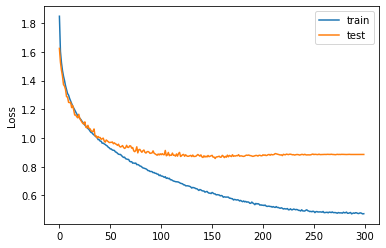

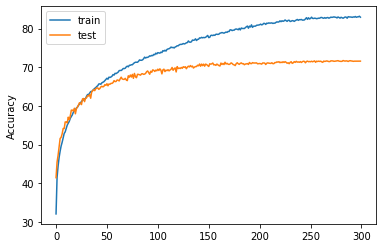


                                Experimenting on cifar10 Dataset 
                                patch:8,
                                sparse_att: True,
                                sparse_mlp: False,
                                num_layers: 4,
                                pos_embed: True,
                                seed: 147
                            
Files already downloaded and verified
Files already downloaded and verified
16 256
ViT Mixer : Channels per patch -> Initial:192 Final:256
[2, 4, 8, 16, 32, 64, 128, 256]
Sequence len: 16 ; Block size: 4
Channel dim: 256 num heads: 16
MLP dim: 256 ; Block size: 256
number of params:  2198794
Model Name: 01.3_ViT_PE_cifar10_patch8_l4_sAtt_mlp_s147
EXPERIMENT DONE... SKIPPING : 01.3_ViT_PE_cifar10_patch8_l4_sAtt_mlp_s147

                                Experimenting on cifar10 Dataset 
                                patch:8,
                                sparse_att: True,
                                sparse_mlp:

100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.36it/s]


[Train] 0 Loss: 1.886 | Acc: 30.702 15351/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.82it/s]


[Test] 0 Loss: 1.660 | Acc: 39.560 3956/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.25it/s]


[Train] 1 Loss: 1.636 | Acc: 40.404 20202/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.24it/s]


[Test] 1 Loss: 1.516 | Acc: 45.430 4543/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.51it/s]


[Train] 2 Loss: 1.542 | Acc: 43.856 21928/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.12it/s]


[Test] 2 Loss: 1.470 | Acc: 47.760 4776/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.37it/s]


[Train] 3 Loss: 1.480 | Acc: 46.342 23171/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.62it/s]


[Test] 3 Loss: 1.394 | Acc: 49.720 4972/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.61it/s]


[Train] 4 Loss: 1.437 | Acc: 48.066 24033/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.54it/s]


[Test] 4 Loss: 1.347 | Acc: 51.900 5190/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.51it/s]


[Train] 5 Loss: 1.397 | Acc: 49.598 24799/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.69it/s]


[Test] 5 Loss: 1.315 | Acc: 53.190 5319/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.62it/s]


[Train] 6 Loss: 1.357 | Acc: 50.874 25437/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.41it/s]


[Test] 6 Loss: 1.298 | Acc: 53.690 5369/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.38it/s]


[Train] 7 Loss: 1.326 | Acc: 51.998 25999/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.05it/s]


[Test] 7 Loss: 1.276 | Acc: 54.020 5402/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.41it/s]


[Train] 8 Loss: 1.299 | Acc: 53.200 26600/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.44it/s]


[Test] 8 Loss: 1.252 | Acc: 54.960 5496/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.46it/s]


[Train] 9 Loss: 1.279 | Acc: 54.026 27013/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.70it/s]


[Test] 9 Loss: 1.218 | Acc: 55.890 5589/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.68it/s]


[Train] 10 Loss: 1.254 | Acc: 54.868 27434/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.02it/s]


[Test] 10 Loss: 1.228 | Acc: 55.790 5579/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.43it/s]


[Train] 11 Loss: 1.237 | Acc: 55.386 27693/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.12it/s]


[Test] 11 Loss: 1.228 | Acc: 55.960 5596/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.46it/s]


[Train] 12 Loss: 1.219 | Acc: 56.404 28202/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.80it/s]


[Test] 12 Loss: 1.190 | Acc: 57.450 5745/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.38it/s]


[Train] 13 Loss: 1.203 | Acc: 56.730 28365/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.35it/s]


[Test] 13 Loss: 1.171 | Acc: 58.010 5801/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.50it/s]


[Train] 14 Loss: 1.186 | Acc: 57.512 28756/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.78it/s]


[Test] 14 Loss: 1.168 | Acc: 58.170 5817/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.30it/s]


[Train] 15 Loss: 1.166 | Acc: 58.148 29074/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.03it/s]


[Test] 15 Loss: 1.136 | Acc: 59.330 5933/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.34it/s]


[Train] 16 Loss: 1.158 | Acc: 58.462 29231/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.51it/s]


[Test] 16 Loss: 1.126 | Acc: 59.800 5980/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.53it/s]


[Train] 17 Loss: 1.142 | Acc: 59.308 29654/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.20it/s]


[Test] 17 Loss: 1.134 | Acc: 59.100 5910/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.38it/s]


[Train] 18 Loss: 1.124 | Acc: 59.778 29889/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.03it/s]


[Test] 18 Loss: 1.124 | Acc: 59.460 5946/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.37it/s]


[Train] 19 Loss: 1.114 | Acc: 60.002 30001/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.89it/s]


[Test] 19 Loss: 1.113 | Acc: 59.690 5969/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.55it/s]


[Train] 20 Loss: 1.103 | Acc: 60.490 30245/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.00it/s]


[Test] 20 Loss: 1.119 | Acc: 59.770 5977/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.44it/s]


[Train] 21 Loss: 1.094 | Acc: 60.790 30395/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.50it/s]


[Test] 21 Loss: 1.112 | Acc: 60.190 6019/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.57it/s]


[Train] 22 Loss: 1.078 | Acc: 61.558 30779/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.83it/s]


[Test] 22 Loss: 1.107 | Acc: 60.150 6015/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.26it/s]


[Train] 23 Loss: 1.071 | Acc: 61.860 30930/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.78it/s]


[Test] 23 Loss: 1.079 | Acc: 61.420 6142/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.41it/s]


[Train] 24 Loss: 1.052 | Acc: 62.352 31176/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.60it/s]


[Test] 24 Loss: 1.077 | Acc: 61.960 6196/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.43it/s]


[Train] 25 Loss: 1.046 | Acc: 62.628 31314/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.20it/s]


[Test] 25 Loss: 1.092 | Acc: 61.190 6119/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.46it/s]


[Train] 26 Loss: 1.042 | Acc: 62.620 31310/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.93it/s]


[Test] 26 Loss: 1.057 | Acc: 62.520 6252/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.42it/s]


[Train] 27 Loss: 1.032 | Acc: 63.262 31631/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.74it/s]


[Test] 27 Loss: 1.050 | Acc: 62.840 6284/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.36it/s]


[Train] 28 Loss: 1.024 | Acc: 63.360 31680/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.02it/s]


[Test] 28 Loss: 1.061 | Acc: 62.580 6258/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.37it/s]


[Train] 29 Loss: 1.010 | Acc: 64.070 32035/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.14it/s]


[Test] 29 Loss: 1.053 | Acc: 62.240 6224/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.48it/s]


[Train] 30 Loss: 1.000 | Acc: 64.520 32260/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.02it/s]


[Test] 30 Loss: 1.030 | Acc: 63.200 6320/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.18it/s]


[Train] 31 Loss: 0.987 | Acc: 64.904 32452/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.51it/s]


[Test] 31 Loss: 1.043 | Acc: 62.530 6253/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.49it/s]


[Train] 32 Loss: 0.983 | Acc: 64.946 32473/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.12it/s]


[Test] 32 Loss: 1.022 | Acc: 63.890 6389/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.32it/s]


[Train] 33 Loss: 0.972 | Acc: 65.464 32732/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.03it/s]


[Test] 33 Loss: 1.022 | Acc: 63.970 6397/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.37it/s]


[Train] 34 Loss: 0.974 | Acc: 65.258 32629/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.84it/s]


[Test] 34 Loss: 1.028 | Acc: 63.260 6326/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.46it/s]


[Train] 35 Loss: 0.963 | Acc: 65.744 32872/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.46it/s]


[Test] 35 Loss: 1.004 | Acc: 64.130 6413/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.63it/s]


[Train] 36 Loss: 0.955 | Acc: 65.896 32948/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.52it/s]


[Test] 36 Loss: 0.994 | Acc: 64.720 6472/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.36it/s]


[Train] 37 Loss: 0.949 | Acc: 66.278 33139/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.94it/s]


[Test] 37 Loss: 0.995 | Acc: 64.840 6484/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.49it/s]


[Train] 38 Loss: 0.942 | Acc: 66.446 33223/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.95it/s]


[Test] 38 Loss: 0.997 | Acc: 65.020 6502/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.46it/s]


[Train] 39 Loss: 0.940 | Acc: 66.352 33176/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.39it/s]


[Test] 39 Loss: 0.988 | Acc: 65.360 6536/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.30it/s]


[Train] 40 Loss: 0.925 | Acc: 66.882 33441/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.11it/s]


[Test] 40 Loss: 1.002 | Acc: 64.800 6480/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.48it/s]


[Train] 41 Loss: 0.929 | Acc: 66.914 33457/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.71it/s]


[Test] 41 Loss: 0.995 | Acc: 64.720 6472/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.63it/s]


[Train] 42 Loss: 0.916 | Acc: 67.468 33734/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.01it/s]


[Test] 42 Loss: 0.988 | Acc: 65.050 6505/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.47it/s]


[Train] 43 Loss: 0.901 | Acc: 67.964 33982/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.91it/s]


[Test] 43 Loss: 0.998 | Acc: 65.100 6510/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.45it/s]


[Train] 44 Loss: 0.907 | Acc: 67.530 33765/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.90it/s]


[Test] 44 Loss: 0.982 | Acc: 65.360 6536/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.46it/s]


[Train] 45 Loss: 0.904 | Acc: 67.952 33976/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.19it/s]


[Test] 45 Loss: 0.972 | Acc: 65.340 6534/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.64it/s]


[Train] 46 Loss: 0.892 | Acc: 68.216 34108/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.40it/s]


[Test] 46 Loss: 0.974 | Acc: 65.680 6568/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.56it/s]


[Train] 47 Loss: 0.884 | Acc: 68.566 34283/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.27it/s]


[Test] 47 Loss: 0.969 | Acc: 65.580 6558/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.52it/s]


[Train] 48 Loss: 0.884 | Acc: 68.532 34266/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.44it/s]


[Test] 48 Loss: 0.957 | Acc: 66.100 6610/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.40it/s]


[Train] 49 Loss: 0.876 | Acc: 68.840 34420/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.36it/s]


[Test] 49 Loss: 0.954 | Acc: 66.010 6601/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.50it/s]


[Train] 50 Loss: 0.871 | Acc: 69.118 34559/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.81it/s]


[Test] 50 Loss: 0.962 | Acc: 66.000 6600/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.55it/s]


[Train] 51 Loss: 0.858 | Acc: 69.672 34836/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.09it/s]


[Test] 51 Loss: 0.964 | Acc: 66.010 6601/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.48it/s]


[Train] 52 Loss: 0.852 | Acc: 69.830 34915/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.59it/s]


[Test] 52 Loss: 0.956 | Acc: 66.360 6636/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.53it/s]


[Train] 53 Loss: 0.855 | Acc: 69.500 34750/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.98it/s]


[Test] 53 Loss: 0.966 | Acc: 65.950 6595/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.41it/s]


[Train] 54 Loss: 0.853 | Acc: 69.706 34853/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.46it/s]


[Test] 54 Loss: 0.959 | Acc: 66.220 6622/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.40it/s]


[Train] 55 Loss: 0.837 | Acc: 70.296 35148/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.29it/s]


[Test] 55 Loss: 0.958 | Acc: 66.650 6665/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.39it/s]


[Train] 56 Loss: 0.833 | Acc: 70.236 35118/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.41it/s]


[Test] 56 Loss: 0.940 | Acc: 66.930 6693/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.51it/s]


[Train] 57 Loss: 0.836 | Acc: 70.312 35156/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.13it/s]


[Test] 57 Loss: 0.949 | Acc: 66.680 6668/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.36it/s]


[Train] 58 Loss: 0.830 | Acc: 70.690 35345/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.93it/s]


[Test] 58 Loss: 0.941 | Acc: 66.990 6699/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.24it/s]


[Train] 59 Loss: 0.822 | Acc: 70.654 35327/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.49it/s]


[Test] 59 Loss: 0.943 | Acc: 67.110 6711/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.54it/s]


[Train] 60 Loss: 0.825 | Acc: 70.836 35418/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.96it/s]


[Test] 60 Loss: 0.943 | Acc: 66.980 6698/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.35it/s]


[Train] 61 Loss: 0.814 | Acc: 71.126 35563/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.16it/s]


[Test] 61 Loss: 0.943 | Acc: 67.240 6724/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.49it/s]


[Train] 62 Loss: 0.811 | Acc: 71.044 35522/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.92it/s]


[Test] 62 Loss: 0.933 | Acc: 67.600 6760/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.42it/s]


[Train] 63 Loss: 0.807 | Acc: 71.318 35659/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.31it/s]


[Test] 63 Loss: 0.931 | Acc: 67.140 6714/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.35it/s]


[Train] 64 Loss: 0.805 | Acc: 71.464 35732/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.81it/s]


[Test] 64 Loss: 0.923 | Acc: 67.800 6780/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.23it/s]


[Train] 65 Loss: 0.789 | Acc: 71.838 35919/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.90it/s]


[Test] 65 Loss: 0.937 | Acc: 67.350 6735/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.36it/s]


[Train] 66 Loss: 0.792 | Acc: 71.804 35902/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.72it/s]


[Test] 66 Loss: 0.951 | Acc: 67.280 6728/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.33it/s]


[Train] 67 Loss: 0.787 | Acc: 72.020 36010/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.97it/s]


[Test] 67 Loss: 0.940 | Acc: 67.250 6725/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.56it/s]


[Train] 68 Loss: 0.783 | Acc: 72.268 36134/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.05it/s]


[Test] 68 Loss: 0.931 | Acc: 67.620 6762/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.12it/s]


[Train] 69 Loss: 0.780 | Acc: 72.364 36182/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.82it/s]


[Test] 69 Loss: 0.944 | Acc: 67.240 6724/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.44it/s]


[Train] 70 Loss: 0.774 | Acc: 72.476 36238/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.76it/s]


[Test] 70 Loss: 0.924 | Acc: 67.710 6771/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.53it/s]


[Train] 71 Loss: 0.770 | Acc: 72.500 36250/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.09it/s]


[Test] 71 Loss: 0.952 | Acc: 67.360 6736/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.39it/s]


[Train] 72 Loss: 0.767 | Acc: 72.850 36425/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.56it/s]


[Test] 72 Loss: 0.915 | Acc: 68.130 6813/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.45it/s]


[Train] 73 Loss: 0.767 | Acc: 72.598 36299/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.58it/s]


[Test] 73 Loss: 0.912 | Acc: 68.330 6833/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.57it/s]


[Train] 74 Loss: 0.760 | Acc: 73.066 36533/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.43it/s]


[Test] 74 Loss: 0.919 | Acc: 68.130 6813/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.37it/s]


[Train] 75 Loss: 0.756 | Acc: 73.210 36605/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.57it/s]


[Test] 75 Loss: 0.932 | Acc: 67.980 6798/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.45it/s]


[Train] 76 Loss: 0.753 | Acc: 73.294 36647/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.46it/s]


[Test] 76 Loss: 0.938 | Acc: 67.380 6738/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.60it/s]


[Train] 77 Loss: 0.748 | Acc: 73.310 36655/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.07it/s]


[Test] 77 Loss: 0.932 | Acc: 67.900 6790/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.52it/s]


[Train] 78 Loss: 0.747 | Acc: 73.436 36718/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.59it/s]


[Test] 78 Loss: 0.924 | Acc: 67.870 6787/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.37it/s]


[Train] 79 Loss: 0.742 | Acc: 73.490 36745/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.01it/s]


[Test] 79 Loss: 0.922 | Acc: 68.060 6806/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.36it/s]


[Train] 80 Loss: 0.737 | Acc: 73.848 36924/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.02it/s]


[Test] 80 Loss: 0.909 | Acc: 68.200 6820/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.32it/s]


[Train] 81 Loss: 0.732 | Acc: 73.950 36975/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.95it/s]


[Test] 81 Loss: 0.909 | Acc: 68.890 6889/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.64it/s]


[Train] 82 Loss: 0.726 | Acc: 74.132 37066/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.76it/s]


[Test] 82 Loss: 0.903 | Acc: 69.090 6909/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.19it/s]


[Train] 83 Loss: 0.726 | Acc: 74.224 37112/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.16it/s]


[Test] 83 Loss: 0.905 | Acc: 68.720 6872/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.45it/s]


[Train] 84 Loss: 0.727 | Acc: 74.012 37006/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.81it/s]


[Test] 84 Loss: 0.918 | Acc: 68.010 6801/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.57it/s]


[Train] 85 Loss: 0.717 | Acc: 74.360 37180/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.90it/s]


[Test] 85 Loss: 0.917 | Acc: 68.500 6850/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.66it/s]


[Train] 86 Loss: 0.718 | Acc: 74.630 37315/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.70it/s]


[Test] 86 Loss: 0.912 | Acc: 68.450 6845/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.45it/s]


[Train] 87 Loss: 0.713 | Acc: 74.834 37417/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.52it/s]


[Test] 87 Loss: 0.907 | Acc: 68.930 6893/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.46it/s]


[Train] 88 Loss: 0.708 | Acc: 74.668 37334/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.58it/s]


[Test] 88 Loss: 0.900 | Acc: 68.460 6846/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.45it/s]


[Train] 89 Loss: 0.704 | Acc: 75.086 37543/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.43it/s]


[Test] 89 Loss: 0.915 | Acc: 68.450 6845/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.30it/s]


[Train] 90 Loss: 0.703 | Acc: 74.688 37344/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.25it/s]


[Test] 90 Loss: 0.903 | Acc: 68.700 6870/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.37it/s]


[Train] 91 Loss: 0.694 | Acc: 75.252 37626/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.65it/s]


[Test] 91 Loss: 0.900 | Acc: 68.830 6883/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.41it/s]


[Train] 92 Loss: 0.697 | Acc: 75.148 37574/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.40it/s]


[Test] 92 Loss: 0.907 | Acc: 68.950 6895/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.51it/s]


[Train] 93 Loss: 0.692 | Acc: 75.182 37591/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.50it/s]


[Test] 93 Loss: 0.905 | Acc: 68.860 6886/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.25it/s]


[Train] 94 Loss: 0.684 | Acc: 75.534 37767/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.43it/s]


[Test] 94 Loss: 0.919 | Acc: 68.720 6872/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.63it/s]


[Train] 95 Loss: 0.686 | Acc: 75.526 37763/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.50it/s]


[Test] 95 Loss: 0.903 | Acc: 68.680 6868/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.46it/s]


[Train] 96 Loss: 0.681 | Acc: 75.768 37884/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.51it/s]


[Test] 96 Loss: 0.894 | Acc: 69.420 6942/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.49it/s]


[Train] 97 Loss: 0.678 | Acc: 75.846 37923/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.88it/s]


[Test] 97 Loss: 0.909 | Acc: 68.960 6896/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.22it/s]


[Train] 98 Loss: 0.677 | Acc: 75.932 37966/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.78it/s]


[Test] 98 Loss: 0.906 | Acc: 68.930 6893/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.46it/s]


[Train] 99 Loss: 0.679 | Acc: 75.818 37909/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.46it/s]


[Test] 99 Loss: 0.895 | Acc: 69.010 6901/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.71it/s]


[Train] 100 Loss: 0.669 | Acc: 76.284 38142/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.05it/s]


[Test] 100 Loss: 0.925 | Acc: 68.490 6849/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.65it/s]


[Train] 101 Loss: 0.666 | Acc: 76.344 38172/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.92it/s]


[Test] 101 Loss: 0.898 | Acc: 68.760 6876/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.42it/s]


[Train] 102 Loss: 0.661 | Acc: 76.364 38182/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.45it/s]


[Test] 102 Loss: 0.903 | Acc: 69.110 6911/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.51it/s]


[Train] 103 Loss: 0.661 | Acc: 76.560 38280/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.11it/s]


[Test] 103 Loss: 0.904 | Acc: 69.200 6920/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.41it/s]


[Train] 104 Loss: 0.662 | Acc: 76.468 38234/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.87it/s]


[Test] 104 Loss: 0.929 | Acc: 68.410 6841/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.50it/s]


[Train] 105 Loss: 0.653 | Acc: 76.678 38339/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.51it/s]


[Test] 105 Loss: 0.906 | Acc: 68.880 6888/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.51it/s]


[Train] 106 Loss: 0.649 | Acc: 76.900 38450/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.99it/s]


[Test] 106 Loss: 0.909 | Acc: 69.420 6942/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.52it/s]


[Train] 107 Loss: 0.653 | Acc: 76.482 38241/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.20it/s]


[Test] 107 Loss: 0.896 | Acc: 69.520 6952/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.61it/s]


[Train] 108 Loss: 0.649 | Acc: 76.696 38348/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.82it/s]


[Test] 108 Loss: 0.905 | Acc: 69.240 6924/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.54it/s]


[Train] 109 Loss: 0.640 | Acc: 77.106 38553/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.40it/s]


[Test] 109 Loss: 0.887 | Acc: 69.570 6957/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.54it/s]


[Train] 110 Loss: 0.639 | Acc: 77.334 38667/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.63it/s]


[Test] 110 Loss: 0.902 | Acc: 69.670 6967/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.55it/s]


[Train] 111 Loss: 0.635 | Acc: 77.260 38630/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.80it/s]


[Test] 111 Loss: 0.909 | Acc: 69.520 6952/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.65it/s]


[Train] 112 Loss: 0.634 | Acc: 76.962 38481/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.95it/s]


[Test] 112 Loss: 0.916 | Acc: 69.190 6919/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.74it/s]


[Train] 113 Loss: 0.633 | Acc: 77.454 38727/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.76it/s]


[Test] 113 Loss: 0.899 | Acc: 69.620 6962/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.56it/s]


[Train] 114 Loss: 0.630 | Acc: 77.380 38690/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.40it/s]


[Test] 114 Loss: 0.901 | Acc: 69.750 6975/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.50it/s]


[Train] 115 Loss: 0.631 | Acc: 77.530 38765/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.67it/s]


[Test] 115 Loss: 0.896 | Acc: 69.870 6987/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.48it/s]


[Train] 116 Loss: 0.621 | Acc: 77.790 38895/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.39it/s]


[Test] 116 Loss: 0.906 | Acc: 69.580 6958/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.47it/s]


[Train] 117 Loss: 0.619 | Acc: 78.046 39023/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.48it/s]


[Test] 117 Loss: 0.932 | Acc: 69.310 6931/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.75it/s]


[Train] 118 Loss: 0.617 | Acc: 77.902 38951/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.35it/s]


[Test] 118 Loss: 0.901 | Acc: 69.630 6963/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.65it/s]


[Train] 119 Loss: 0.617 | Acc: 78.164 39082/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.36it/s]


[Test] 119 Loss: 0.905 | Acc: 69.840 6984/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.49it/s]


[Train] 120 Loss: 0.617 | Acc: 78.062 39031/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.61it/s]


[Test] 120 Loss: 0.906 | Acc: 69.740 6974/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.53it/s]


[Train] 121 Loss: 0.609 | Acc: 78.190 39095/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.60it/s]


[Test] 121 Loss: 0.901 | Acc: 69.640 6964/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.67it/s]


[Train] 122 Loss: 0.605 | Acc: 78.084 39042/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.94it/s]


[Test] 122 Loss: 0.911 | Acc: 69.570 6957/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.47it/s]


[Train] 123 Loss: 0.603 | Acc: 78.466 39233/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.54it/s]


[Test] 123 Loss: 0.916 | Acc: 69.660 6966/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.28it/s]


[Train] 124 Loss: 0.601 | Acc: 78.530 39265/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.03it/s]


[Test] 124 Loss: 0.923 | Acc: 69.490 6949/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.61it/s]


[Train] 125 Loss: 0.594 | Acc: 78.894 39447/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.89it/s]


[Test] 125 Loss: 0.904 | Acc: 69.740 6974/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.67it/s]


[Train] 126 Loss: 0.597 | Acc: 78.868 39434/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.39it/s]


[Test] 126 Loss: 0.903 | Acc: 69.840 6984/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.40it/s]


[Train] 127 Loss: 0.589 | Acc: 79.000 39500/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.31it/s]


[Test] 127 Loss: 0.902 | Acc: 70.000 7000/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.50it/s]


[Train] 128 Loss: 0.590 | Acc: 79.042 39521/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.50it/s]


[Test] 128 Loss: 0.907 | Acc: 69.760 6976/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.61it/s]


[Train] 129 Loss: 0.589 | Acc: 78.934 39467/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.36it/s]


[Test] 129 Loss: 0.912 | Acc: 69.960 6996/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.65it/s]


[Train] 130 Loss: 0.583 | Acc: 79.000 39500/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.65it/s]


[Test] 130 Loss: 0.896 | Acc: 70.190 7019/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.36it/s]


[Train] 131 Loss: 0.582 | Acc: 79.202 39601/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.74it/s]


[Test] 131 Loss: 0.908 | Acc: 69.780 6978/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.30it/s]


[Train] 132 Loss: 0.585 | Acc: 79.104 39552/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.47it/s]


[Test] 132 Loss: 0.899 | Acc: 70.410 7041/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.54it/s]


[Train] 133 Loss: 0.583 | Acc: 79.380 39690/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.15it/s]


[Test] 133 Loss: 0.912 | Acc: 69.780 6978/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.57it/s]


[Train] 134 Loss: 0.573 | Acc: 79.600 39800/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.96it/s]


[Test] 134 Loss: 0.908 | Acc: 70.350 7035/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.41it/s]


[Train] 135 Loss: 0.574 | Acc: 79.476 39738/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.94it/s]


[Test] 135 Loss: 0.919 | Acc: 69.670 6967/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.46it/s]


[Train] 136 Loss: 0.572 | Acc: 79.738 39869/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.67it/s]


[Test] 136 Loss: 0.919 | Acc: 69.410 6941/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.52it/s]


[Train] 137 Loss: 0.572 | Acc: 79.554 39777/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.61it/s]


[Test] 137 Loss: 0.908 | Acc: 69.990 6999/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.79it/s]


[Train] 138 Loss: 0.566 | Acc: 79.612 39806/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.71it/s]


[Test] 138 Loss: 0.921 | Acc: 69.890 6989/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.73it/s]


[Train] 139 Loss: 0.566 | Acc: 79.618 39809/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.42it/s]


[Test] 139 Loss: 0.918 | Acc: 69.960 6996/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.39it/s]


[Train] 140 Loss: 0.568 | Acc: 79.698 39849/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.60it/s]


[Test] 140 Loss: 0.911 | Acc: 70.090 7009/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.56it/s]


[Train] 141 Loss: 0.555 | Acc: 80.142 40071/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.93it/s]


[Test] 141 Loss: 0.906 | Acc: 70.330 7033/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.50it/s]


[Train] 142 Loss: 0.558 | Acc: 79.764 39882/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.97it/s]


[Test] 142 Loss: 0.912 | Acc: 69.970 6997/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.41it/s]


[Train] 143 Loss: 0.556 | Acc: 80.136 40068/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.85it/s]


[Test] 143 Loss: 0.915 | Acc: 70.260 7026/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.54it/s]


[Train] 144 Loss: 0.554 | Acc: 80.112 40056/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.73it/s]


[Test] 144 Loss: 0.919 | Acc: 69.890 6989/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.58it/s]


[Train] 145 Loss: 0.551 | Acc: 80.312 40156/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.13it/s]


[Test] 145 Loss: 0.899 | Acc: 70.380 7038/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.53it/s]


[Train] 146 Loss: 0.554 | Acc: 80.222 40111/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.25it/s]


[Test] 146 Loss: 0.913 | Acc: 70.000 7000/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.64it/s]


[Train] 147 Loss: 0.548 | Acc: 80.408 40204/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.09it/s]


[Test] 147 Loss: 0.913 | Acc: 70.350 7035/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.52it/s]


[Train] 148 Loss: 0.549 | Acc: 80.474 40237/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.52it/s]


[Test] 148 Loss: 0.901 | Acc: 70.790 7079/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.41it/s]


[Train] 149 Loss: 0.550 | Acc: 80.198 40099/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.51it/s]


[Test] 149 Loss: 0.908 | Acc: 70.430 7043/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.40it/s]


[Train] 150 Loss: 0.542 | Acc: 80.514 40257/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.83it/s]


[Test] 150 Loss: 0.921 | Acc: 70.060 7006/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.67it/s]


[Train] 151 Loss: 0.538 | Acc: 80.816 40408/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.76it/s]


[Test] 151 Loss: 0.914 | Acc: 70.330 7033/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.67it/s]


[Train] 152 Loss: 0.539 | Acc: 80.702 40351/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.80it/s]


[Test] 152 Loss: 0.910 | Acc: 70.540 7054/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.55it/s]


[Train] 153 Loss: 0.536 | Acc: 80.806 40403/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.28it/s]


[Test] 153 Loss: 0.915 | Acc: 70.240 7024/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.73it/s]


[Train] 154 Loss: 0.532 | Acc: 80.908 40454/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.44it/s]


[Test] 154 Loss: 0.913 | Acc: 70.200 7020/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.51it/s]


[Train] 155 Loss: 0.527 | Acc: 81.430 40715/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.35it/s]


[Test] 155 Loss: 0.918 | Acc: 70.520 7052/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.54it/s]


[Train] 156 Loss: 0.525 | Acc: 81.148 40574/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.98it/s]


[Test] 156 Loss: 0.923 | Acc: 70.240 7024/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.27it/s]


[Train] 157 Loss: 0.528 | Acc: 81.082 40541/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.97it/s]


[Test] 157 Loss: 0.923 | Acc: 70.120 7012/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.27it/s]


[Train] 158 Loss: 0.527 | Acc: 81.246 40623/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.31it/s]


[Test] 158 Loss: 0.909 | Acc: 70.560 7056/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.59it/s]


[Train] 159 Loss: 0.526 | Acc: 81.116 40558/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.09it/s]


[Test] 159 Loss: 0.917 | Acc: 70.320 7032/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.52it/s]


[Train] 160 Loss: 0.525 | Acc: 81.208 40604/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.80it/s]


[Test] 160 Loss: 0.927 | Acc: 69.800 6980/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.66it/s]


[Train] 161 Loss: 0.517 | Acc: 81.538 40769/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.95it/s]


[Test] 161 Loss: 0.911 | Acc: 70.120 7012/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.57it/s]


[Train] 162 Loss: 0.516 | Acc: 81.512 40756/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.56it/s]


[Test] 162 Loss: 0.916 | Acc: 70.310 7031/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.61it/s]


[Train] 163 Loss: 0.513 | Acc: 81.820 40910/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.08it/s]


[Test] 163 Loss: 0.918 | Acc: 70.270 7027/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.57it/s]


[Train] 164 Loss: 0.513 | Acc: 81.582 40791/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.78it/s]


[Test] 164 Loss: 0.930 | Acc: 70.000 7000/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.57it/s]


[Train] 165 Loss: 0.509 | Acc: 81.852 40926/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.19it/s]


[Test] 165 Loss: 0.925 | Acc: 70.300 7030/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.61it/s]


[Train] 166 Loss: 0.509 | Acc: 81.936 40968/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.57it/s]


[Test] 166 Loss: 0.923 | Acc: 70.460 7046/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.52it/s]


[Train] 167 Loss: 0.510 | Acc: 81.874 40937/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.13it/s]


[Test] 167 Loss: 0.923 | Acc: 70.590 7059/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.67it/s]


[Train] 168 Loss: 0.504 | Acc: 81.986 40993/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.10it/s]


[Test] 168 Loss: 0.934 | Acc: 70.090 7009/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.58it/s]


[Train] 169 Loss: 0.502 | Acc: 81.960 40980/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.87it/s]


[Test] 169 Loss: 0.916 | Acc: 70.680 7068/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.56it/s]


[Train] 170 Loss: 0.504 | Acc: 81.908 40954/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.09it/s]


[Test] 170 Loss: 0.933 | Acc: 70.230 7023/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.44it/s]


[Train] 171 Loss: 0.499 | Acc: 82.170 41085/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.29it/s]


[Test] 171 Loss: 0.929 | Acc: 70.110 7011/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.47it/s]


[Train] 172 Loss: 0.500 | Acc: 82.102 41051/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.95it/s]


[Test] 172 Loss: 0.923 | Acc: 70.550 7055/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.54it/s]


[Train] 173 Loss: 0.497 | Acc: 82.150 41075/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.20it/s]


[Test] 173 Loss: 0.929 | Acc: 70.400 7040/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.48it/s]


[Train] 174 Loss: 0.494 | Acc: 82.438 41219/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.25it/s]


[Test] 174 Loss: 0.938 | Acc: 70.510 7051/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.56it/s]


[Train] 175 Loss: 0.493 | Acc: 82.386 41193/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.67it/s]


[Test] 175 Loss: 0.928 | Acc: 70.530 7053/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.42it/s]


[Train] 176 Loss: 0.492 | Acc: 82.536 41268/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.96it/s]


[Test] 176 Loss: 0.921 | Acc: 70.420 7042/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.64it/s]


[Train] 177 Loss: 0.487 | Acc: 82.600 41300/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.63it/s]


[Test] 177 Loss: 0.923 | Acc: 70.730 7073/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.72it/s]


[Train] 178 Loss: 0.488 | Acc: 82.394 41197/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.90it/s]


[Test] 178 Loss: 0.927 | Acc: 70.450 7045/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.52it/s]


[Train] 179 Loss: 0.487 | Acc: 82.466 41233/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.89it/s]


[Test] 179 Loss: 0.936 | Acc: 70.250 7025/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.49it/s]


[Train] 180 Loss: 0.487 | Acc: 82.592 41296/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.53it/s]


[Test] 180 Loss: 0.933 | Acc: 70.340 7034/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.36it/s]


[Train] 181 Loss: 0.487 | Acc: 82.388 41194/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.38it/s]


[Test] 181 Loss: 0.925 | Acc: 70.400 7040/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.27it/s]


[Train] 182 Loss: 0.476 | Acc: 83.000 41500/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.44it/s]


[Test] 182 Loss: 0.931 | Acc: 70.540 7054/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.46it/s]


[Train] 183 Loss: 0.477 | Acc: 82.834 41417/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.50it/s]


[Test] 183 Loss: 0.936 | Acc: 70.160 7016/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.48it/s]


[Train] 184 Loss: 0.477 | Acc: 82.778 41389/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.61it/s]


[Test] 184 Loss: 0.929 | Acc: 70.750 7075/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.42it/s]


[Train] 185 Loss: 0.479 | Acc: 82.754 41377/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.36it/s]


[Test] 185 Loss: 0.940 | Acc: 70.380 7038/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.52it/s]


[Train] 186 Loss: 0.480 | Acc: 82.800 41400/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.76it/s]


[Test] 186 Loss: 0.925 | Acc: 70.710 7071/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.44it/s]


[Train] 187 Loss: 0.472 | Acc: 83.064 41532/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.63it/s]


[Test] 187 Loss: 0.930 | Acc: 70.880 7088/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.22it/s]


[Train] 188 Loss: 0.470 | Acc: 83.232 41616/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.64it/s]


[Test] 188 Loss: 0.927 | Acc: 70.710 7071/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.46it/s]


[Train] 189 Loss: 0.472 | Acc: 82.976 41488/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.84it/s]


[Test] 189 Loss: 0.921 | Acc: 70.690 7069/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.36it/s]


[Train] 190 Loss: 0.475 | Acc: 82.886 41443/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.30it/s]


[Test] 190 Loss: 0.929 | Acc: 70.590 7059/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.65it/s]


[Train] 191 Loss: 0.467 | Acc: 83.224 41612/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.50it/s]


[Test] 191 Loss: 0.925 | Acc: 70.870 7087/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.61it/s]


[Train] 192 Loss: 0.469 | Acc: 83.258 41629/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.65it/s]


[Test] 192 Loss: 0.931 | Acc: 70.610 7061/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.67it/s]


[Train] 193 Loss: 0.466 | Acc: 83.322 41661/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.60it/s]


[Test] 193 Loss: 0.935 | Acc: 70.410 7041/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.59it/s]


[Train] 194 Loss: 0.467 | Acc: 83.280 41640/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.01it/s]


[Test] 194 Loss: 0.936 | Acc: 70.630 7063/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.53it/s]


[Train] 195 Loss: 0.465 | Acc: 83.376 41688/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.42it/s]


[Test] 195 Loss: 0.934 | Acc: 70.770 7077/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.57it/s]


[Train] 196 Loss: 0.466 | Acc: 83.436 41718/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.43it/s]


[Test] 196 Loss: 0.936 | Acc: 70.420 7042/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.49it/s]


[Train] 197 Loss: 0.459 | Acc: 83.614 41807/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.92it/s]


[Test] 197 Loss: 0.936 | Acc: 70.590 7059/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.52it/s]


[Train] 198 Loss: 0.457 | Acc: 83.596 41798/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.95it/s]


[Test] 198 Loss: 0.934 | Acc: 70.700 7070/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.49it/s]


[Train] 199 Loss: 0.455 | Acc: 83.636 41818/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.16it/s]


[Test] 199 Loss: 0.939 | Acc: 70.790 7079/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.80it/s]


[Train] 200 Loss: 0.453 | Acc: 83.656 41828/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.84it/s]


[Test] 200 Loss: 0.941 | Acc: 70.680 7068/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.46it/s]


[Train] 201 Loss: 0.452 | Acc: 83.834 41917/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.34it/s]


[Test] 201 Loss: 0.938 | Acc: 70.540 7054/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.41it/s]


[Train] 202 Loss: 0.450 | Acc: 84.026 42013/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.61it/s]


[Test] 202 Loss: 0.952 | Acc: 70.260 7026/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.42it/s]


[Train] 203 Loss: 0.449 | Acc: 83.952 41976/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.32it/s]


[Test] 203 Loss: 0.940 | Acc: 71.000 7100/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.47it/s]


[Train] 204 Loss: 0.452 | Acc: 83.796 41898/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.52it/s]


[Test] 204 Loss: 0.941 | Acc: 70.570 7057/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.47it/s]


[Train] 205 Loss: 0.448 | Acc: 83.964 41982/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.64it/s]


[Test] 205 Loss: 0.949 | Acc: 70.270 7027/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.30it/s]


[Train] 206 Loss: 0.448 | Acc: 83.980 41990/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.65it/s]


[Test] 206 Loss: 0.937 | Acc: 70.630 7063/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.42it/s]


[Train] 207 Loss: 0.448 | Acc: 83.982 41991/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.77it/s]


[Test] 207 Loss: 0.932 | Acc: 70.960 7096/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.49it/s]


[Train] 208 Loss: 0.445 | Acc: 84.202 42101/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.43it/s]


[Test] 208 Loss: 0.946 | Acc: 70.490 7049/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.59it/s]


[Train] 209 Loss: 0.441 | Acc: 84.270 42135/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.41it/s]


[Test] 209 Loss: 0.949 | Acc: 70.400 7040/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.65it/s]


[Train] 210 Loss: 0.447 | Acc: 83.970 41985/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.02it/s]


[Test] 210 Loss: 0.943 | Acc: 70.690 7069/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.60it/s]


[Train] 211 Loss: 0.440 | Acc: 84.308 42154/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.75it/s]


[Test] 211 Loss: 0.946 | Acc: 70.730 7073/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.63it/s]


[Train] 212 Loss: 0.441 | Acc: 84.346 42173/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.00it/s]


[Test] 212 Loss: 0.950 | Acc: 70.580 7058/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.70it/s]


[Train] 213 Loss: 0.446 | Acc: 84.064 42032/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.90it/s]


[Test] 213 Loss: 0.948 | Acc: 70.410 7041/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.51it/s]


[Train] 214 Loss: 0.436 | Acc: 84.468 42234/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.93it/s]


[Test] 214 Loss: 0.942 | Acc: 70.800 7080/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.38it/s]


[Train] 215 Loss: 0.438 | Acc: 84.312 42156/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.78it/s]


[Test] 215 Loss: 0.952 | Acc: 70.830 7083/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.66it/s]


[Train] 216 Loss: 0.439 | Acc: 84.284 42142/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.12it/s]


[Test] 216 Loss: 0.946 | Acc: 70.840 7084/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.70it/s]


[Train] 217 Loss: 0.435 | Acc: 84.552 42276/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.57it/s]


[Test] 217 Loss: 0.946 | Acc: 70.580 7058/10000


100%|███████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.33it/s]


[Train] 218 Loss: 0.438 | Acc: 84.368 42184/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.81it/s]


[Test] 218 Loss: 0.946 | Acc: 70.690 7069/10000


 39%|████████████████████                               | 154/391 [00:04<00:05, 40.69it/s]

In [ ]:
### Automate the benchmark
###### for c10 / c100

not_working = [
    (1, False, False, 4),
    (1, False, False, 8),
    (1, False, False, 12),
    (1, False, True, 4),
    (1, False, True, 8),
    (1, False, True, 12),

    (1, True, False, 12),
    (1, True, True, 12),
]

cuda_idx = 0
for dataset in ['cifar10']:
    for seed in [147, 258, 369]:
        for nlayers in [4, 8, 12]:
            for patch_size in [8, 4, 2, 1]:
                for sparse_attention in [False, True]:
                    for sparse_mlp in [False, True]:
#                         for PE in [True, False]:
                        for PE in [False]:

                            print(f'''
                                Experimenting on {dataset} Dataset 
                                patch:{patch_size},
                                sparse_att: {sparse_attention},
                                sparse_mlp: {sparse_mlp},
                                num_layers: {nlayers},
                                pos_embed: {PE},
                                seed: {seed}
                            ''')

                        ### check if config is in not_working case
                            exit = False
                            for nw in not_working:
                                if patch_size==nw[0] and \
                                    sparse_attention==nw[1] and \
                                    sparse_mlp==nw[2] and\
                                    nlayers==nw[3]:

                                    exit=True
                                    break
                            if exit:
                                print(f'Exiting as the config is in NOT WORKING')
                                continue


                            benchmark(dataset=dataset, 
                                      patch_size=patch_size, 
                                      num_layers=nlayers, 
                                      SEED=seed, 
                                      sparse_att=sparse_attention, sparse_mlp=sparse_mlp, 
                                      pos_emb=PE,
                                      cuda=cuda_idx
                                     )

In [ ]:
asdasdasd

In [ ]:
## Use mixing 

In [ ]:
### TODO: Experiments
'''
1. Sparse Attention
2. Sparse MLP
3. Sparse Att + MLP

Datasets:
A. Cifar-10/100 -> 4x4 vs 2x2 vs 1x1 patch
B. Tiny-Imagenet -> 16x16 vs 4x4 vs 2x2 patch
'''

In [ ]:
'''
## Cifar 10/100

vit_mixer = Mixer_ViT_Classifier((3, 32, 32), patch_size=[8, 8], hidden_channel=256, num_blocks=6, num_classes=200, block_seq_size=4, block_mlp_size=16)

vit_mixer = Mixer_ViT_Classifier((3, 32, 32), patch_size=[4, 4], hidden_channel=128, num_blocks=3, num_classes=10, block_seq_size=8, block_mlp_size=128)

vit_mixer = Mixer_ViT_Classifier((3, 32, 32), patch_size=[2, 2], hidden_channel=64, num_blocks=3, num_classes=10, block_seq_size=16, block_mlp_size=8)

vit_mixer = Mixer_ViT_Classifier((3, 32, 32), patch_size=[1, 1], hidden_channel=64, num_blocks=3, num_classes=10, block_seq_size=32, block_mlp_size=8)

'''

In [ ]:
'''
vit_mixer = Mixer_ViT_Classifier((3, 64, 64), patch_size=[4, 4], hidden_channel=128, num_blocks=9, num_classes=200, block_seq_size=16, block_mlp_size=16)
Sequence len: 256 ; Block size: 16
Channel dim: 128 num heads: 8
MLP dim: 128 ; Block size: 16


vit_mixer = Mixer_ViT_Classifier((3, 64, 64), patch_size=[8, 8], hidden_channel=256, num_blocks=9, num_classes=200, block_seq_size=8, block_mlp_size=16)
Sequence len: 64 ; Block size: 16
Channel dim: 256 num heads: 16
MLP dim: 256 ; Block size: 16

vit_mixer = Mixer_ViT_Classifier((3, 64, 64), patch_size=[16, 16], hidden_channel=1024, num_blocks=9, num_classes=200, block_seq_size=4, block_mlp_size=32)
Sequence len: 16 ; Block size: 4
Channel dim: 1024 num heads: 32
MLP dim: 1024 ; Block size: 32
'''

### Automate the model creation

In [ ]:
img = 64
patch_size = [16, 8, 4, 2, 1]
expansion = [1024, 256, 128, 64, 64]

for i in range(len(patch_size)):
    ps, exp = patch_size[i], expansion[i]
    print(i, ps, exp)
    seq_len = (img//ps)**2
    print('seq:', seq_len)
    
    fact_seq = int(2**np.ceil(np.log2(np.sqrt(seq_len))))
    print(f'fact_seq: {fact_seq}')
    
    
    fact_mlp = int(2**np.ceil(np.log2(np.sqrt(exp))))
    print(f'fact_mlp: {fact_mlp}')